# Cool Pearson Correlation Tables and PCA

In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from pandas import DataFrame
import dask.dataframe as dd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import shap
import time
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

# Pathogenic Coding:

Below is the dataframe for the pathogenic coding region:

In [10]:
pathogenic_coding_region = pd.read_csv("pathogenic_coding_region_variants.csv")
pathogenic_coding_region.head()

/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,114,116,118,120,122,124,126,128,130,138,141,144,147,150,153,156,159,162,167,170,173,181,182,202,203,204,207,236,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,#Chrom,Pos,Ref,Alt,Type,Length,AnnoType,Consequence,ConsScore,...,BP4,BP5,BP6,BP7,cosmic70,MCAP,REVEL,regsnp_fpr,regsnp_disease,regsnp_splicing_site
0,0,1,1014143,C,T,SNV,0,CodingTranscript,STOP_GAINED,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1014143,C,T,SNV,0,Intergenic,UPSTREAM,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,1014143,C,T,SNV,0,RegulatoryFeature,REGULATORY,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,1014143,C,T,SNV,0,RegulatoryFeature,REGULATORY,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,1022225,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below we have cut out columns we will not use for our model, since they do not improve the model's learning ability:

In [11]:
pathogenic_coding_region = pathogenic_coding_region.drop(columns = ['Unnamed: 0', '#Chrom', 'Pos', 'Length', 'End', 'Type', 'AnnoType'])

We set a new column so that we can distinguish this data from the other regions:

In [12]:
pathogenic_coding_region['category'] = 'pathogenic_coding'

Below we keep only the numerical columns for PCA:

In [13]:
pathogenic_coding_region_for_pca = pathogenic_coding_region[['ConsScore', 'GC', 'CpG', 'motifECount', 'motifEHIPos', 'motifEScoreChng', 'cDNApos', 'relcDNApos', 'CDSpos', 'relCDSpos', 'protPos', 'relProtPos', 'Dst2Splice', 'minDistTSS', 'minDistTSE', 'SIFTval', 'mamPhCons', 'verPhCons', 'priPhyloP', 'mamPhyloP', 'verPhyloP', 'bStatistic', 'targetScan', 'mirSVR-Score', 'mirSVR-E', 'mirSVR-Aln', 'GerpRS', 'GerpRSpval', 'tOverlapMotifs', 'motifDist', 'EncodeH3K4me1-sum', 'EncodeH3K4me1-max', 'EncodeH3K4me2-sum', 'EncodeH3K4me2-max', 'EncodeH3K4me3-sum', 'EncodeH3K4me3-max', 'EncodeH3K9ac-sum', 'EncodeH3K9ac-max', 'EncodeH3K9me3-sum', 'EncodeH3K9me3-max', 'EncodeH3K27ac-sum', 'EncodeH3K27ac-max', 'EncodeH3K27me3-sum', 'EncodeH3K27me3-max', 'EncodeH3K36me3-sum', 'EncodeH3K36me3-max', 'EncodeH3K79me2-sum', 'EncodeH3K79me2-max', 'EncodeH4K20me1-sum', 'EncodeH4K20me1-max', 'EncodeH2AFZ-sum', 'EncodeH2AFZ-max', 'EncodeDNase-sum', 'EncodeDNase-max', 'EncodetotalRNA-sum', 'EncodetotalRNA-max', 'Grantham', 'Dist2Mutation', 'Freq100bp', 'Rare100bp', 'Sngl100bp', 'Freq1000bp', 'Rare1000bp', 'Sngl1000bp', 'Freq10000bp', 'Rare10000bp', 'Sngl10000bp', 'dbscSNV-ada_score', 'dbscSNV-rf_score', 'RemapOverlapTF', 'RemapOverlapCL', 'RawScore', 'PHRED', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score', 'LRT_score', 'MutationTaster_score', 'MutationAssessor_score', 'FATHMM_score', 'RadialSVM_score', 'LR_score', 'VEST3_score', 'CADD_raw', 'CADD_phred', 'GERP++_RS', 'phyloP46way_placental', 'phyloP100way_vertebrate', 'SiPhy_29way_logOdds', 'SIFT_score.1', 'SIFT_converted_rankscore', 'Polyphen2_HDIV_score.1', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score.1', 'Polyphen2_HVAR_rankscore', 'LRT_score.1', 'LRT_converted_rankscore', 'MutationTaster_score.1', 'MutationTaster_converted_rankscore', 'MutationAssessor_score.1', 'MutationAssessor_score_rankscore', 'FATHMM_score.1', 'FATHMM_converted_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST3_score.1', 'VEST3_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'CADD_raw.1', 'CADD_raw_rankscore', 'CADD_phred.1', 'DANN_score', 'DANN_rankscore', 'fathmm-MKL_coding_score', 'fathmm-MKL_coding_rankscore', 'Eigen-raw', 'Eigen-PC-raw', 'GenoCanyon_score', 'GenoCanyon_score_rankscore', 'integrated_fitCons_score', 'integrated_fitCons_score_rankscore', 'integrated_confidence_value', 'GERP++_RS.1', 'GERP++_RS_rankscore', 'phyloP100way_vertebrate.1', 'phyloP100way_vertebrate_rankscore', 'phyloP20way_mammalian', 'phyloP20way_mammalian_rankscore', 'phastCons100way_vertebrate', 'phastCons100way_vertebrate_rankscore', 'phastCons20way_mammalian', 'phastCons20way_mammalian_rankscore', 'SiPhy_29way_logOdds.1', 'SiPhy_29way_logOdds_rankscore', 'dbscSNV_ADA_SCORE', 'dbscSNV_RF_SCORE', 'PVS1', 'PS1', 'PS2', 'PS3', 'PS4', 'PM1', 'PM2', 'PM3', 'PM4', 'PM5', 'PM6', 'PP1', 'PP2', 'PP3', 'PP4', 'PP5', 'BA1', 'BS1', 'BS2', 'BS3', 'BS4', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'MCAP', 'REVEL', 'regsnp_fpr', 'category']]

We must fill all NaN values with 0 to use PCA. The code for this is shown below:

In [14]:
pathogenic_coding_region_for_pca_without_categorical_columns_no_nan = pathogenic_coding_region_for_pca.fillna(0)

Below I will save this dataframe for use in other Notebooks and in this Notebook if there is a memory error in the future:

In [14]:
pathogenic_coding_region_for_pca_without_categorical_columns_no_nan.to_csv('pathogenic_coding_region_for_pca.csv')

Below is a Pearson Correlation Test for the Benign Coding Region Variants and a graph to go along with it. We must change the dtype of the annotations since this test does not work on objects and that is what all of the annovar annotations are designated as. Since We cannot have '.' as values in our dataframe, we must change them to NaN values. Also, Python does not allow NaN values to be changed to integers so we must change all values to float regardless of if they are truly integer values or not.

The following code changes all scores and other numerical outputs to floats from objects for both CADD and ANNOVAR:

In [58]:
pathogenic_coding_region_variants_with_nan = pathogenic_coding_region_variants.replace('.', np.nan)
pathogenic_coding_region_variants_with_nan = pathogenic_coding_region_variants_with_nan.astype({'SIFT_score': float, 'Polyphen2_HDIV_score' : float, 
                'Polyphen2_HVAR_score' : float, 'LRT_score' : float, 
                'MutationTaster_score' : float, 'MutationAssessor_score' : float, 
                'FATHMM_score' : float, 'RadialSVM_score' : float,
               'LR_score' : float, 'VEST3_score' : float, 'CADD_raw' : float,
               'CADD_phred' : float, 'GERP++_RS' : float, 'phyloP46way_placental' : float,
               'phyloP100way_vertebrate' : float, 'SiPhy_29way_logOdds' : float, 'SIFT_score.1' : float,
               'SIFT_converted_rankscore' : float, 'Polyphen2_HDIV_score.1' : float, 'Polyphen2_HDIV_rankscore' : float,
               'Polyphen2_HVAR_score.1' : float, 'Polyphen2_HVAR_rankscore' : float, 'LRT_score.1' : float,
               'LRT_converted_rankscore' : float, 'MutationTaster_score.1' : float, 'MutationTaster_converted_rankscore' : float,
               'MutationAssessor_score.1' : float, 'MutationAssessor_score_rankscore' : float, 'FATHMM_score.1' : float,
               'FATHMM_converted_rankscore' : float, 'PROVEAN_score' : float, 'PROVEAN_converted_rankscore' : float,
               'VEST3_score.1' : float, 'VEST3_rankscore' : float, 'MetaSVM_score' : float, 'MetaSVM_rankscore' : float,
               'MetaLR_score' : float, 'MetaLR_rankscore' : float, 'M-CAP_score' : float, 'M-CAP_rankscore' : float,
               'CADD_raw.1' : float, 'CADD_raw_rankscore' : float, 'CADD_phred.1' : float, 'DANN_score' : float,
               'DANN_rankscore' : float, 'fathmm-MKL_coding_score' : float, 'fathmm-MKL_coding_rankscore' : float,
               'Eigen-raw' : float, 'Eigen-PC-raw' : float, 'GenoCanyon_score' : float, 'GenoCanyon_score_rankscore' : float,
               'integrated_fitCons_score' : float, 'integrated_fitCons_score_rankscore' : float, 'integrated_confidence_value' : float,
               'GERP++_RS.1' : float, 'GERP++_RS_rankscore' : float, 'phyloP100way_vertebrate.1' : float, 
                'phyloP100way_vertebrate_rankscore' : float, 'phyloP20way_mammalian' : float, 'phyloP20way_mammalian_rankscore' : float,
               'phastCons100way_vertebrate' : float, 'phastCons100way_vertebrate_rankscore' : float, 'phastCons20way_mammalian' : float,
               'phastCons20way_mammalian_rankscore' : float, 'SiPhy_29way_logOdds.1' : float, 'SiPhy_29way_logOdds_rankscore' : float,
               'dbscSNV_ADA_SCORE' : float, 'dbscSNV_RF_SCORE' : float, 'PVS1' : float, 'PS1' : float, 'PS2' : float, 'PS3' : float,
               'PS4' : float, 'PM1' : float, 'PM2' : float, 'PM3' : float, 'PM4' : float, 'PM5' : float, 'PM6' : float, 'PP1' : float, 'PP2' : float,
               'PP3' : float, 'PP4' : float, 'PP5' : float, 'BA1' : float, 'BS1' : float, 'BS2' : float, 'BS3' : float, 'BS4' : float, 'BP1' : float, 'BP2' : float,
               'BP3' : float, 'BP4' : float, 'BP5' : float, 'BP6' : float, 'BP7' : float, 'MCAP' : float, 'REVEL' : float, 'regsnp_fpr' : float,
                'dbscSNV-rf_score' : float})

Below I have saved the resulting file for use in other notebooks:

In [59]:
pathogenic_coding_region_variants_with_nan.to_csv('pathogenic_coding_region_variants.csv')

Below I have run the Pearson Correlation Test on the annotations for the pathogenic coding region and created a graph that plots the correlation between the annotations:

In [68]:
pd.options.display.max_rows = 230
correlation_for_pathogenic_coding_region = pathogenic_coding_region_variants_with_nan.corr(method = 'pearson')
correlation_for_pathogenic_coding_region.to_csv('correlation_for_pathogenic_coding_region.csv')
correlation_for_pathogenic_coding_region

,Pos,Length,ConsScore,GC,CpG,...,BP6,BP7,MCAP,REVEL,regsnp_fpr
Pos,1.000000,0.004213,0.060003,-0.117562,-0.101529,...,0.004720,0.007840,0.083869,-0.029684,0.057593
Length,0.004213,1.000000,-0.009324,-0.018070,-0.014945,...,NaN,NaN,NaN,NaN,NaN
ConsScore,0.060003,-0.009324,1.000000,-0.158386,-0.118213,...,-0.000325,-0.023326,-0.060990,0.011331,-0.081053
GC,-0.117562,-0.018070,-0.158386,1.000000,0.768257,...,0.023922,0.004661,-0.118202,-0.172529,0.382296
CpG,-0.101529,-0.014945,-0.118213,0.768257,1.000000,...,0.021967,0.016249,-0.150045,-0.253363,0.471763
motifECount,0.094962,0.527683,0.004699,-0.076297,-0.047251,...,0.009982,NaN,-0.022260,-0.123770,-0.631042
motifEHIPos,0.014591,-0.057939,0.000999,0.021879,0.003205,...,-0.063068,NaN,-0.001093,-0.097403,0.676505
motifEScoreChng,-0.000744,-0.062101,-0.022809,-0.018791,-0.021555,...,0.061025,NaN,0.046637,0.074861,0.405605
cDNApos,0.054283,0.002080,0.035992,-0.100347,-0.113350,...,-0.001039,0.003455,-0.041171,-0.069547,NaN
relcDNApos,-0.017585,0.010466,-0.081215,0.017474,-0.113563,...,0.029199,0.003895,0.006706,-0.027900,NaN


Below shows the list of annotations in the Pearson Correlation test:

In [17]:
list(correlation_for_pathogenic_coding_region)

['Pos',
 'Length',
 'ConsScore',
 'GC',
 'CpG',
 'motifECount',
 'motifEHIPos',
 'motifEScoreChng',
 'cDNApos',
 'relcDNApos',
 'CDSpos',
 'relCDSpos',
 'protPos',
 'relProtPos',
 'Dst2Splice',
 'minDistTSS',
 'minDistTSE',
 'SIFTval',
 'mamPhCons',
 'verPhCons',
 'priPhyloP',
 'mamPhyloP',
 'verPhyloP',
 'bStatistic',
 'targetScan',
 'mirSVR-Score',
 'mirSVR-E',
 'mirSVR-Aln',
 'GerpRS',
 'GerpRSpval',
 'tOverlapMotifs',
 'motifDist',
 'EncodeH3K4me1-sum',
 'EncodeH3K4me1-max',
 'EncodeH3K4me2-sum',
 'EncodeH3K4me2-max',
 'EncodeH3K4me3-sum',
 'EncodeH3K4me3-max',
 'EncodeH3K9ac-sum',
 'EncodeH3K9ac-max',
 'EncodeH3K9me3-sum',
 'EncodeH3K9me3-max',
 'EncodeH3K27ac-sum',
 'EncodeH3K27ac-max',
 'EncodeH3K27me3-sum',
 'EncodeH3K27me3-max',
 'EncodeH3K36me3-sum',
 'EncodeH3K36me3-max',
 'EncodeH3K79me2-sum',
 'EncodeH3K79me2-max',
 'EncodeH4K20me1-sum',
 'EncodeH4K20me1-max',
 'EncodeH2AFZ-sum',
 'EncodeH2AFZ-max',
 'EncodeDNase-sum',
 'EncodeDNase-max',
 'EncodetotalRNA-sum',
 'Encodetot

Below is the graph for the correlation of the annotations for the pathogenic coding region:

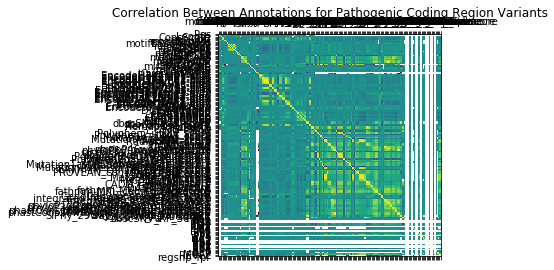

In [18]:
plt.matshow(pathogenic_coding_region_variants_with_nan.corr(method = 'pearson'))
annotations = ['Pos',
 'Length',
 'ConsScore',
 'GC',
 'CpG',
 'motifECount',
 'motifEHIPos',
 'motifEScoreChng',
 'cDNApos',
 'relcDNApos',
 'CDSpos',
 'relCDSpos',
 'protPos',
 'relProtPos',
 'Dst2Splice',
 'minDistTSS',
 'minDistTSE',
 'SIFTval',
 'mamPhCons',
 'verPhCons',
 'priPhyloP',
 'mamPhyloP',
 'verPhyloP',
 'bStatistic',
 'targetScan',
 'mirSVR-Score',
 'mirSVR-E',
 'mirSVR-Aln',
 'GerpRS',
 'GerpRSpval',
 'tOverlapMotifs',
 'motifDist',
 'EncodeH3K4me1-sum',
 'EncodeH3K4me1-max',
 'EncodeH3K4me2-sum',
 'EncodeH3K4me2-max',
 'EncodeH3K4me3-sum',
 'EncodeH3K4me3-max',
 'EncodeH3K9ac-sum',
 'EncodeH3K9ac-max',
 'EncodeH3K9me3-sum',
 'EncodeH3K9me3-max',
 'EncodeH3K27ac-sum',
 'EncodeH3K27ac-max',
 'EncodeH3K27me3-sum',
 'EncodeH3K27me3-max',
 'EncodeH3K36me3-sum',
 'EncodeH3K36me3-max',
 'EncodeH3K79me2-sum',
 'EncodeH3K79me2-max',
 'EncodeH4K20me1-sum',
 'EncodeH4K20me1-max',
 'EncodeH2AFZ-sum',
 'EncodeH2AFZ-max',
 'EncodeDNase-sum',
 'EncodeDNase-max',
 'EncodetotalRNA-sum',
 'EncodetotalRNA-max',
 'Grantham',
 'Dist2Mutation',
 'Freq100bp',
 'Rare100bp',
 'Sngl100bp',
 'Freq1000bp',
 'Rare1000bp',
 'Sngl1000bp',
 'Freq10000bp',
 'Rare10000bp',
 'Sngl10000bp',
 'dbscSNV-ada_score',
 'dbscSNV-rf_score',
 'RemapOverlapTF',
 'RemapOverlapCL',
 'RawScore',
 'PHRED',
 'End',
 'SIFT_score',
 'Polyphen2_HDIV_score',
 'Polyphen2_HVAR_score',
 'LRT_score',
 'MutationTaster_score',
 'MutationAssessor_score',
 'FATHMM_score',
 'RadialSVM_score',
 'LR_score',
 'VEST3_score',
 'CADD_raw',
 'CADD_phred',
 'GERP++_RS',
 'phyloP46way_placental',
 'phyloP100way_vertebrate',
 'SiPhy_29way_logOdds',
 'SIFT_score.1',
 'SIFT_converted_rankscore',
 'Polyphen2_HDIV_score.1',
 'Polyphen2_HDIV_rankscore',
 'Polyphen2_HVAR_score.1',
 'Polyphen2_HVAR_rankscore',
 'LRT_score.1',
 'LRT_converted_rankscore',
 'MutationTaster_score.1',
 'MutationTaster_converted_rankscore',
 'MutationAssessor_score.1',
 'MutationAssessor_score_rankscore',
 'FATHMM_score.1',
 'FATHMM_converted_rankscore',
 'PROVEAN_score',
 'PROVEAN_converted_rankscore',
 'VEST3_score.1',
 'VEST3_rankscore',
 'MetaSVM_score',
 'MetaSVM_rankscore',
 'MetaLR_score',
 'MetaLR_rankscore',
 'M-CAP_score',
 'M-CAP_rankscore',
 'CADD_raw.1',
 'CADD_raw_rankscore',
 'CADD_phred.1',
 'DANN_score',
 'DANN_rankscore',
 'fathmm-MKL_coding_score',
 'fathmm-MKL_coding_rankscore',
 'Eigen-raw',
 'Eigen-PC-raw',
 'GenoCanyon_score',
 'GenoCanyon_score_rankscore',
 'integrated_fitCons_score',
 'integrated_fitCons_score_rankscore',
 'integrated_confidence_value',
 'GERP++_RS.1',
 'GERP++_RS_rankscore',
 'phyloP100way_vertebrate.1',
 'phyloP100way_vertebrate_rankscore',
 'phyloP20way_mammalian',
 'phyloP20way_mammalian_rankscore',
 'phastCons100way_vertebrate',
 'phastCons100way_vertebrate_rankscore',
 'phastCons20way_mammalian',
 'phastCons20way_mammalian_rankscore',
 'SiPhy_29way_logOdds.1',
 'SiPhy_29way_logOdds_rankscore',
 'dbscSNV_ADA_SCORE',
 'dbscSNV_RF_SCORE',
 'PVS1',
 'PS1',
 'PS2',
 'PS3',
 'PS4',
 'PM1',
 'PM2',
 'PM3',
 'PM4',
 'PM5',
 'PM6',
 'PP1',
 'PP2',
 'PP3',
 'PP4',
 'PP5',
 'BA1',
 'BS1',
 'BS2',
 'BS3',
 'BS4',
 'BP1',
 'BP2',
 'BP3',
 'BP4',
 'BP5',
 'BP6',
 'BP7',
 'MCAP',
 'REVEL',
 'regsnp_fpr']
x_pos = np.arange(len(annotations))
plt.xticks(x_pos, annotations)
y_pos = np.arange(len(annotations))
plt.yticks(y_pos, annotations)
plt.title('Correlation Between Annotations for Pathogenic Coding Region Variants')
plt.show()

Below is a cleaner picture since it does not have all the annotations around the axes. The blue in this graph means that annotation correlations are not large in these regions. Since the majority of the graph is blue, we may be able to cut out some columns in our dataframe for the model:

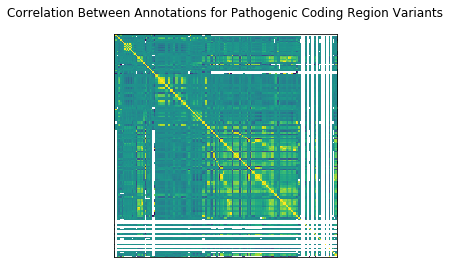

In [19]:
plt.matshow(pathogenic_coding_region_variants_with_nan.corr(method = 'pearson'))
plt.title('Correlation Between Annotations for Pathogenic Coding Region Variants')
plt.xticks([])
plt.yticks([])
plt.show()

# Benign Coding:

Below is the dataframe for the benign coding region:

In [15]:
benign_coding_region = pd.read_csv("benign_coding_region_variants.csv")
benign_coding_region.head()

/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,114,116,118,120,122,124,126,128,130,138,141,144,147,150,153,156,159,162,167,170,173,181,182,202,203,204,207,236,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,#Chrom,Pos,Ref,Alt,Type,Length,AnnoType,Consequence,ConsScore,...,BP4,BP5,BP6,BP7,cosmic70,MCAP,REVEL,regsnp_fpr,regsnp_disease,regsnp_splicing_site
0,0,1,1014042,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1014042,G,A,SNV,0,Intergenic,UPSTREAM,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,1014042,G,A,SNV,0,RegulatoryFeature,REGULATORY,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,1014042,G,A,SNV,0,RegulatoryFeature,REGULATORY,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,1014217,C,T,SNV,0,CodingTranscript,SYNONYMOUS,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Again we cut out the columns not helpful to our model:

In [16]:
benign_coding_region = benign_coding_region.drop(columns = ['Unnamed: 0', '#Chrom', 'Pos', 'Length', 'End', 'Type', 'AnnoType'])

We set a new column so that we can distinguish this data from the other regions:

In [17]:
benign_coding_region['category'] = 'benign_coding'

Below we keep only the numerical columns for PCA:

In [18]:
benign_coding_region_for_pca = benign_coding_region[['ConsScore', 'GC', 'CpG', 'motifECount', 'motifEHIPos', 'motifEScoreChng', 'cDNApos', 'relcDNApos', 'CDSpos', 'relCDSpos', 'protPos', 'relProtPos', 'Dst2Splice', 'minDistTSS', 'minDistTSE', 'SIFTval', 'mamPhCons', 'verPhCons', 'priPhyloP', 'mamPhyloP', 'verPhyloP', 'bStatistic', 'targetScan', 'mirSVR-Score', 'mirSVR-E', 'mirSVR-Aln', 'GerpRS', 'GerpRSpval', 'tOverlapMotifs', 'motifDist', 'EncodeH3K4me1-sum', 'EncodeH3K4me1-max', 'EncodeH3K4me2-sum', 'EncodeH3K4me2-max', 'EncodeH3K4me3-sum', 'EncodeH3K4me3-max', 'EncodeH3K9ac-sum', 'EncodeH3K9ac-max', 'EncodeH3K9me3-sum', 'EncodeH3K9me3-max', 'EncodeH3K27ac-sum', 'EncodeH3K27ac-max', 'EncodeH3K27me3-sum', 'EncodeH3K27me3-max', 'EncodeH3K36me3-sum', 'EncodeH3K36me3-max', 'EncodeH3K79me2-sum', 'EncodeH3K79me2-max', 'EncodeH4K20me1-sum', 'EncodeH4K20me1-max', 'EncodeH2AFZ-sum', 'EncodeH2AFZ-max', 'EncodeDNase-sum', 'EncodeDNase-max', 'EncodetotalRNA-sum', 'EncodetotalRNA-max', 'Grantham', 'Dist2Mutation', 'Freq100bp', 'Rare100bp', 'Sngl100bp', 'Freq1000bp', 'Rare1000bp', 'Sngl1000bp', 'Freq10000bp', 'Rare10000bp', 'Sngl10000bp', 'dbscSNV-ada_score', 'dbscSNV-rf_score', 'RemapOverlapTF', 'RemapOverlapCL', 'RawScore', 'PHRED', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score', 'LRT_score', 'MutationTaster_score', 'MutationAssessor_score', 'FATHMM_score', 'RadialSVM_score', 'LR_score', 'VEST3_score', 'CADD_raw', 'CADD_phred', 'GERP++_RS', 'phyloP46way_placental', 'phyloP100way_vertebrate', 'SiPhy_29way_logOdds', 'SIFT_score.1', 'SIFT_converted_rankscore', 'Polyphen2_HDIV_score.1', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score.1', 'Polyphen2_HVAR_rankscore', 'LRT_score.1', 'LRT_converted_rankscore', 'MutationTaster_score.1', 'MutationTaster_converted_rankscore', 'MutationAssessor_score.1', 'MutationAssessor_score_rankscore', 'FATHMM_score.1', 'FATHMM_converted_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST3_score.1', 'VEST3_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'CADD_raw.1', 'CADD_raw_rankscore', 'CADD_phred.1', 'DANN_score', 'DANN_rankscore', 'fathmm-MKL_coding_score', 'fathmm-MKL_coding_rankscore', 'Eigen-raw', 'Eigen-PC-raw', 'GenoCanyon_score', 'GenoCanyon_score_rankscore', 'integrated_fitCons_score', 'integrated_fitCons_score_rankscore', 'integrated_confidence_value', 'GERP++_RS.1', 'GERP++_RS_rankscore', 'phyloP100way_vertebrate.1', 'phyloP100way_vertebrate_rankscore', 'phyloP20way_mammalian', 'phyloP20way_mammalian_rankscore', 'phastCons100way_vertebrate', 'phastCons100way_vertebrate_rankscore', 'phastCons20way_mammalian', 'phastCons20way_mammalian_rankscore', 'SiPhy_29way_logOdds.1', 'SiPhy_29way_logOdds_rankscore', 'dbscSNV_ADA_SCORE', 'dbscSNV_RF_SCORE', 'PVS1', 'PS1', 'PS2', 'PS3', 'PS4', 'PM1', 'PM2', 'PM3', 'PM4', 'PM5', 'PM6', 'PP1', 'PP2', 'PP3', 'PP4', 'PP5', 'BA1', 'BS1', 'BS2', 'BS3', 'BS4', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'MCAP', 'REVEL', 'regsnp_fpr', 'category']]

We must fill all NaN values with 0 to use PCA. The code for this is shown below:

In [19]:
benign_coding_region_for_pca_without_categorical_columns_no_nan = benign_coding_region_for_pca.fillna(0)

Below I will save this dataframe for use in other Notebooks and in this Notebook if there is a memory error in the future:

In [20]:
benign_coding_region_for_pca_without_categorical_columns_no_nan.to_csv('benign_coding_region_for_pca.csv')

The following code changes all scores and other numerical outputs to floats from objects for both CADD and ANNOVAR:

In [ ]:
benign_coding_region_variants_with_nan = benign_coding_region_variants.replace('.', np.nan)
benign_coding_region_variants_with_nan = benign_coding_region_variants_with_nan.astype({'SIFT_score': float, 'Polyphen2_HDIV_score' : float, 
                'Polyphen2_HVAR_score' : float, 'LRT_score' : float, 
                'MutationTaster_score' : float, 'MutationAssessor_score' : float, 
                'FATHMM_score' : float, 'RadialSVM_score' : float,
               'LR_score' : float, 'VEST3_score' : float, 'CADD_raw' : float,
               'CADD_phred' : float, 'GERP++_RS' : float, 'phyloP46way_placental' : float,
               'phyloP100way_vertebrate' : float, 'SiPhy_29way_logOdds' : float, 'SIFT_score.1' : float,
               'SIFT_converted_rankscore' : float, 'Polyphen2_HDIV_score.1' : float, 'Polyphen2_HDIV_rankscore' : float,
               'Polyphen2_HVAR_score.1' : float, 'Polyphen2_HVAR_rankscore' : float, 'LRT_score.1' : float,
               'LRT_converted_rankscore' : float, 'MutationTaster_score.1' : float, 'MutationTaster_converted_rankscore' : float,
               'MutationAssessor_score.1' : float, 'MutationAssessor_score_rankscore' : float, 'FATHMM_score.1' : float,
               'FATHMM_converted_rankscore' : float, 'PROVEAN_score' : float, 'PROVEAN_converted_rankscore' : float,
               'VEST3_score.1' : float, 'VEST3_rankscore' : float, 'MetaSVM_score' : float, 'MetaSVM_rankscore' : float,
               'MetaLR_score' : float, 'MetaLR_rankscore' : float, 'M-CAP_score' : float, 'M-CAP_rankscore' : float,
               'CADD_raw.1' : float, 'CADD_raw_rankscore' : float, 'CADD_phred.1' : float, 'DANN_score' : float,
               'DANN_rankscore' : float, 'fathmm-MKL_coding_score' : float, 'fathmm-MKL_coding_rankscore' : float,
               'Eigen-raw' : float, 'Eigen-PC-raw' : float, 'GenoCanyon_score' : float, 'GenoCanyon_score_rankscore' : float,
               'integrated_fitCons_score' : float, 'integrated_fitCons_score_rankscore' : float, 'integrated_confidence_value' : float,
               'GERP++_RS.1' : float, 'GERP++_RS_rankscore' : float, 'phyloP100way_vertebrate.1' : float, 
                'phyloP100way_vertebrate_rankscore' : float, 'phyloP20way_mammalian' : float, 'phyloP20way_mammalian_rankscore' : float,
               'phastCons100way_vertebrate' : float, 'phastCons100way_vertebrate_rankscore' : float, 'phastCons20way_mammalian' : float,
               'phastCons20way_mammalian_rankscore' : float, 'SiPhy_29way_logOdds.1' : float, 'SiPhy_29way_logOdds_rankscore' : float,
               'dbscSNV_ADA_SCORE' : float, 'dbscSNV_RF_SCORE' : float, 'PVS1' : float, 'PS1' : float, 'PS2' : float, 'PS3' : float,
               'PS4' : float, 'PM1' : float, 'PM2' : float, 'PM3' : float, 'PM4' : float, 'PM5' : float, 'PM6' : float, 'PP1' : float, 'PP2' : float,
               'PP3' : float, 'PP4' : float, 'PP5' : float, 'BA1' : float, 'BS1' : float, 'BS2' : float, 'BS3' : float, 'BS4' : float, 'BP1' : float, 'BP2' : float,
               'BP3' : float, 'BP4' : float, 'BP5' : float, 'BP6' : float, 'BP7' : float, 'MCAP' : float, 'REVEL' : float, 'regsnp_fpr' : float,
                'dbscSNV-rf_score' : float})

Below I have saved the dataframe for use in other Notebooks:

In [64]:
benign_coding_region_variants_with_nan.to_csv('benign_coding_region_variants.csv')

The code below contains the pearson correlation chart for all the numerical annotations:

In [69]:
pd.options.display.max_rows = 230
correlation_for_benign_coding_region = benign_coding_region_variants_with_nan.corr(method = 'pearson')
correlation_for_benign_coding_region.to_csv('correlation_for_benign_coding_region.csv')
correlation_for_benign_coding_region

,Pos,Length,ConsScore,GC,CpG,...,BP6,BP7,MCAP,REVEL,regsnp_fpr
Pos,1.000000,-0.005898,0.040917,-0.044942,-0.006439,...,-0.012466,0.015307,0.030144,-0.033941,-0.069152
Length,-0.005898,1.000000,0.010617,0.024648,0.027735,...,NaN,NaN,NaN,NaN,NaN
ConsScore,0.040917,0.010617,1.000000,-0.044886,-0.043248,...,0.023049,-0.241612,0.000861,0.025640,-0.094081
GC,-0.044942,0.024648,-0.044886,1.000000,0.806275,...,-0.006253,-0.008410,0.076226,-0.122261,0.100218
CpG,-0.006439,0.027735,-0.043248,0.806275,1.000000,...,-0.044045,-0.021899,0.132726,-0.101929,0.064056
motifECount,0.001885,-0.007846,0.012723,-0.080535,-0.020828,...,-0.174490,0.000776,-0.225748,-0.138363,0.155052
motifEHIPos,0.003689,-0.025607,0.024202,0.022873,0.013708,...,-0.137519,0.302192,0.076672,-0.079142,0.366181
motifEScoreChng,0.013960,-0.020467,-0.013800,-0.054724,-0.038875,...,0.165712,-0.284439,-0.257157,0.104787,-0.008819
cDNApos,0.040027,-0.001590,-0.035048,-0.101361,-0.126159,...,0.041170,0.059582,-0.069909,0.001606,-0.189991
relcDNApos,-0.009011,-0.010379,-0.025880,-0.216956,-0.332400,...,-0.019355,-0.025762,-0.136919,-0.034147,-0.055539


Below shows the list of the annotations in the chart. It is necessary to have this chart so that we can graph the correlation output:

In [86]:
list(correlation_for_benign_coding_region)

['Pos',
 'Length',
 'ConsScore',
 'GC',
 'CpG',
 'motifECount',
 'motifEHIPos',
 'motifEScoreChng',
 'cDNApos',
 'relcDNApos',
 'CDSpos',
 'relCDSpos',
 'protPos',
 'relProtPos',
 'Dst2Splice',
 'minDistTSS',
 'minDistTSE',
 'SIFTval',
 'mamPhCons',
 'verPhCons',
 'priPhyloP',
 'mamPhyloP',
 'verPhyloP',
 'bStatistic',
 'targetScan',
 'mirSVR-Score',
 'mirSVR-E',
 'mirSVR-Aln',
 'GerpRS',
 'GerpRSpval',
 'tOverlapMotifs',
 'motifDist',
 'EncodeH3K4me1-sum',
 'EncodeH3K4me1-max',
 'EncodeH3K4me2-sum',
 'EncodeH3K4me2-max',
 'EncodeH3K4me3-sum',
 'EncodeH3K4me3-max',
 'EncodeH3K9ac-sum',
 'EncodeH3K9ac-max',
 'EncodeH3K9me3-sum',
 'EncodeH3K9me3-max',
 'EncodeH3K27ac-sum',
 'EncodeH3K27ac-max',
 'EncodeH3K27me3-sum',
 'EncodeH3K27me3-max',
 'EncodeH3K36me3-sum',
 'EncodeH3K36me3-max',
 'EncodeH3K79me2-sum',
 'EncodeH3K79me2-max',
 'EncodeH4K20me1-sum',
 'EncodeH4K20me1-max',
 'EncodeH2AFZ-sum',
 'EncodeH2AFZ-max',
 'EncodeDNase-sum',
 'EncodeDNase-max',
 'EncodetotalRNA-sum',
 'Encodetot

Below shows the same graph of the pearson correlation function for all the numerical annotations, the first contains all the annotations on the axes and the second does not contain anything on the axes (it looks a little cleaner so I included it):

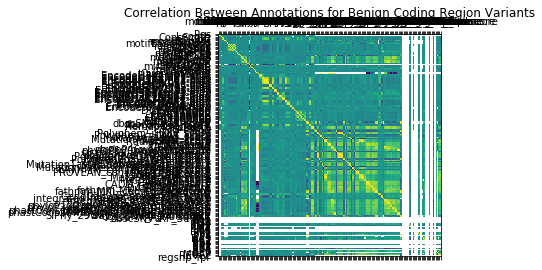

In [87]:
plt.matshow(benign_coding_region_variants_with_nan.corr(method = 'pearson'))
annotations = ['Pos',
 'Length',
 'ConsScore',
 'GC',
 'CpG',
 'motifECount',
 'motifEHIPos',
 'motifEScoreChng',
 'cDNApos',
 'relcDNApos',
 'CDSpos',
 'relCDSpos',
 'protPos',
 'relProtPos',
 'Dst2Splice',
 'minDistTSS',
 'minDistTSE',
 'SIFTval',
 'mamPhCons',
 'verPhCons',
 'priPhyloP',
 'mamPhyloP',
 'verPhyloP',
 'bStatistic',
 'targetScan',
 'mirSVR-Score',
 'mirSVR-E',
 'mirSVR-Aln',
 'GerpRS',
 'GerpRSpval',
 'tOverlapMotifs',
 'motifDist',
 'EncodeH3K4me1-sum',
 'EncodeH3K4me1-max',
 'EncodeH3K4me2-sum',
 'EncodeH3K4me2-max',
 'EncodeH3K4me3-sum',
 'EncodeH3K4me3-max',
 'EncodeH3K9ac-sum',
 'EncodeH3K9ac-max',
 'EncodeH3K9me3-sum',
 'EncodeH3K9me3-max',
 'EncodeH3K27ac-sum',
 'EncodeH3K27ac-max',
 'EncodeH3K27me3-sum',
 'EncodeH3K27me3-max',
 'EncodeH3K36me3-sum',
 'EncodeH3K36me3-max',
 'EncodeH3K79me2-sum',
 'EncodeH3K79me2-max',
 'EncodeH4K20me1-sum',
 'EncodeH4K20me1-max',
 'EncodeH2AFZ-sum',
 'EncodeH2AFZ-max',
 'EncodeDNase-sum',
 'EncodeDNase-max',
 'EncodetotalRNA-sum',
 'EncodetotalRNA-max',
 'Grantham',
 'Dist2Mutation',
 'Freq100bp',
 'Rare100bp',
 'Sngl100bp',
 'Freq1000bp',
 'Rare1000bp',
 'Sngl1000bp',
 'Freq10000bp',
 'Rare10000bp',
 'Sngl10000bp',
 'dbscSNV-ada_score',
 'dbscSNV-rf_score',
 'RemapOverlapTF',
 'RemapOverlapCL',
 'RawScore',
 'PHRED',
 'End',
 'SIFT_score',
 'Polyphen2_HDIV_score',
 'Polyphen2_HVAR_score',
 'LRT_score',
 'MutationTaster_score',
 'MutationAssessor_score',
 'FATHMM_score',
 'RadialSVM_score',
 'LR_score',
 'VEST3_score',
 'CADD_raw',
 'CADD_phred',
 'GERP++_RS',
 'phyloP46way_placental',
 'phyloP100way_vertebrate',
 'SiPhy_29way_logOdds',
 'SIFT_score.1',
 'SIFT_converted_rankscore',
 'Polyphen2_HDIV_score.1',
 'Polyphen2_HDIV_rankscore',
 'Polyphen2_HVAR_score.1',
 'Polyphen2_HVAR_rankscore',
 'LRT_score.1',
 'LRT_converted_rankscore',
 'MutationTaster_score.1',
 'MutationTaster_converted_rankscore',
 'MutationAssessor_score.1',
 'MutationAssessor_score_rankscore',
 'FATHMM_score.1',
 'FATHMM_converted_rankscore',
 'PROVEAN_score',
 'PROVEAN_converted_rankscore',
 'VEST3_score.1',
 'VEST3_rankscore',
 'MetaSVM_score',
 'MetaSVM_rankscore',
 'MetaLR_score',
 'MetaLR_rankscore',
 'M-CAP_score',
 'M-CAP_rankscore',
 'CADD_raw.1',
 'CADD_raw_rankscore',
 'CADD_phred.1',
 'DANN_score',
 'DANN_rankscore',
 'fathmm-MKL_coding_score',
 'fathmm-MKL_coding_rankscore',
 'Eigen-raw',
 'Eigen-PC-raw',
 'GenoCanyon_score',
 'GenoCanyon_score_rankscore',
 'integrated_fitCons_score',
 'integrated_fitCons_score_rankscore',
 'integrated_confidence_value',
 'GERP++_RS.1',
 'GERP++_RS_rankscore',
 'phyloP100way_vertebrate.1',
 'phyloP100way_vertebrate_rankscore',
 'phyloP20way_mammalian',
 'phyloP20way_mammalian_rankscore',
 'phastCons100way_vertebrate',
 'phastCons100way_vertebrate_rankscore',
 'phastCons20way_mammalian',
 'phastCons20way_mammalian_rankscore',
 'SiPhy_29way_logOdds.1',
 'SiPhy_29way_logOdds_rankscore',
 'dbscSNV_ADA_SCORE',
 'dbscSNV_RF_SCORE',
 'PVS1',
 'PS1',
 'PS2',
 'PS3',
 'PS4',
 'PM1',
 'PM2',
 'PM3',
 'PM4',
 'PM5',
 'PM6',
 'PP1',
 'PP2',
 'PP3',
 'PP4',
 'PP5',
 'BA1',
 'BS1',
 'BS2',
 'BS3',
 'BS4',
 'BP1',
 'BP2',
 'BP3',
 'BP4',
 'BP5',
 'BP6',
 'BP7',
 'MCAP',
 'REVEL',
 'regsnp_fpr']
x_pos = np.arange(len(annotations))
plt.xticks(x_pos, annotations)
y_pos = np.arange(len(annotations))
plt.yticks(y_pos, annotations)
plt.title('Correlation Between Annotations for Benign Coding Region Variants')
plt.show()

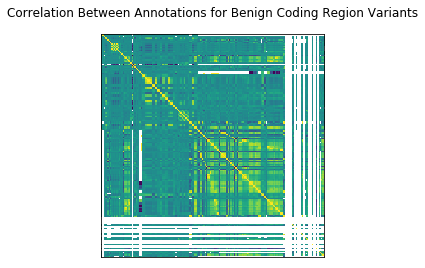

In [88]:
plt.matshow(benign_coding_region_variants_with_nan.corr(method = 'pearson'))
plt.title('Correlation Between Annotations for Benign Coding Region Variants')
plt.xticks([])
plt.yticks([])
plt.show()

# Pathogenic Noncoding:

Below is the dataframe for the pathogenic noncoding region:

In [22]:
pathogenic_noncoding_region = pd.read_csv("pathogenic_noncoding_region_variants.csv")
pathogenic_noncoding_region

/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,#Chrom,Pos,Ref,...,REVEL,regsnp_fpr,regsnp_disease,regsnp_splicing_site
0,0,1,7961859,C,...,NaN,NaN,NaN,NaN
1,1,1,7961859,C,...,NaN,NaN,NaN,NaN
2,2,1,9720021,G,...,NaN,NaN,NaN,NaN
3,3,1,9720021,G,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
11254,2641,X,154419746,G,...,NaN,NaN,NaN,NaN
11255,2642,X,154419746,G,...,NaN,NaN,NaN,NaN
11256,2643,X,154420211,G,...,0.869,NaN,NaN,NaN
11257,2644,X,154420211,G,...,0.869,NaN,NaN,NaN


Again we cut out the columns not helpful to our model:

In [23]:
pathogenic_noncoding_region = pathogenic_noncoding_region.drop(columns =['Unnamed: 0', '#Chrom', 'Pos', 'Length', 'End', 'Type', 'AnnoType'])

We set a new column so that we can distinguish this data from the other regions:

In [24]:
pathogenic_noncoding_region['category'] = 'pathogenic_noncoding'

Below we keep only the numerical columns for PCA:

In [25]:
pathogenic_noncoding_region_for_pca = pathogenic_noncoding_region[['ConsScore', 'GC', 'CpG', 'motifECount', 'motifEHIPos', 'motifEScoreChng', 'cDNApos', 'relcDNApos', 'CDSpos', 'relCDSpos', 'protPos', 'relProtPos', 'Dst2Splice', 'minDistTSS', 'minDistTSE', 'SIFTval', 'mamPhCons', 'verPhCons', 'priPhyloP', 'mamPhyloP', 'verPhyloP', 'bStatistic', 'targetScan', 'mirSVR-Score', 'mirSVR-E', 'mirSVR-Aln', 'GerpRS', 'GerpRSpval', 'tOverlapMotifs', 'motifDist', 'EncodeH3K4me1-sum', 'EncodeH3K4me1-max', 'EncodeH3K4me2-sum', 'EncodeH3K4me2-max', 'EncodeH3K4me3-sum', 'EncodeH3K4me3-max', 'EncodeH3K9ac-sum', 'EncodeH3K9ac-max', 'EncodeH3K9me3-sum', 'EncodeH3K9me3-max', 'EncodeH3K27ac-sum', 'EncodeH3K27ac-max', 'EncodeH3K27me3-sum', 'EncodeH3K27me3-max', 'EncodeH3K36me3-sum', 'EncodeH3K36me3-max', 'EncodeH3K79me2-sum', 'EncodeH3K79me2-max', 'EncodeH4K20me1-sum', 'EncodeH4K20me1-max', 'EncodeH2AFZ-sum', 'EncodeH2AFZ-max', 'EncodeDNase-sum', 'EncodeDNase-max', 'EncodetotalRNA-sum', 'EncodetotalRNA-max', 'Grantham', 'Dist2Mutation', 'Freq100bp', 'Rare100bp', 'Sngl100bp', 'Freq1000bp', 'Rare1000bp', 'Sngl1000bp', 'Freq10000bp', 'Rare10000bp', 'Sngl10000bp', 'dbscSNV-ada_score', 'dbscSNV-rf_score', 'RemapOverlapTF', 'RemapOverlapCL', 'RawScore', 'PHRED', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score', 'LRT_score', 'MutationTaster_score', 'MutationAssessor_score', 'FATHMM_score', 'RadialSVM_score', 'LR_score', 'VEST3_score', 'CADD_raw', 'CADD_phred', 'GERP++_RS', 'phyloP46way_placental', 'phyloP100way_vertebrate', 'SiPhy_29way_logOdds', 'SIFT_score.1', 'SIFT_converted_rankscore', 'Polyphen2_HDIV_score.1', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score.1', 'Polyphen2_HVAR_rankscore', 'LRT_score.1', 'LRT_converted_rankscore', 'MutationTaster_score.1', 'MutationTaster_converted_rankscore', 'MutationAssessor_score.1', 'MutationAssessor_score_rankscore', 'FATHMM_score.1', 'FATHMM_converted_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST3_score.1', 'VEST3_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'CADD_raw.1', 'CADD_raw_rankscore', 'CADD_phred.1', 'DANN_score', 'DANN_rankscore', 'fathmm-MKL_coding_score', 'fathmm-MKL_coding_rankscore', 'Eigen-raw', 'Eigen-PC-raw', 'GenoCanyon_score', 'GenoCanyon_score_rankscore', 'integrated_fitCons_score', 'integrated_fitCons_score_rankscore', 'integrated_confidence_value', 'GERP++_RS.1', 'GERP++_RS_rankscore', 'phyloP100way_vertebrate.1', 'phyloP100way_vertebrate_rankscore', 'phyloP20way_mammalian', 'phyloP20way_mammalian_rankscore', 'phastCons100way_vertebrate', 'phastCons100way_vertebrate_rankscore', 'phastCons20way_mammalian', 'phastCons20way_mammalian_rankscore', 'SiPhy_29way_logOdds.1', 'SiPhy_29way_logOdds_rankscore', 'dbscSNV_ADA_SCORE', 'dbscSNV_RF_SCORE', 'PVS1', 'PS1', 'PS2', 'PS3', 'PS4', 'PM1', 'PM2', 'PM3', 'PM4', 'PM5', 'PM6', 'PP1', 'PP2', 'PP3', 'PP4', 'PP5', 'BA1', 'BS1', 'BS2', 'BS3', 'BS4', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'MCAP', 'REVEL', 'regsnp_fpr', 'category']]

We must fill all NaN values with 0 to use PCA. The code for this is shown below:

In [26]:
pathogenic_noncoding_region_for_pca_without_categorical_columns_no_nan = pathogenic_noncoding_region_for_pca.fillna(0)

Below I will save this dataframe for use in other Notebooks and in this Notebook if there is a memory error in the future:

In [27]:
pathogenic_noncoding_region_for_pca_without_categorical_columns_no_nan.to_csv('pathogenic_noncoding_region_for_pca.csv')

Below I have changed the dtype like before and replaced the empty values with NaN values like before: 

In [50]:
pathogenic_noncoding_region_variants_with_nan = pathogenic_noncoding_region_variants_with_nan.astype({'SIFT_score': float, 'Polyphen2_HDIV_score' : float, 
                'Polyphen2_HVAR_score' : float, 'LRT_score' : float, 
                'MutationTaster_score' : float, 'MutationAssessor_score' : float, 
                'FATHMM_score' : float, 'RadialSVM_score' : float,
               'LR_score' : float, 'VEST3_score' : float, 'CADD_raw' : float,
               'CADD_phred' : float, 'GERP++_RS' : float, 'phyloP46way_placental' : float,
               'phyloP100way_vertebrate' : float, 'SiPhy_29way_logOdds' : float, 'SIFT_score.1' : float,
               'SIFT_converted_rankscore' : float, 'Polyphen2_HDIV_score.1' : float, 'Polyphen2_HDIV_rankscore' : float,
               'Polyphen2_HVAR_score.1' : float, 'Polyphen2_HVAR_rankscore' : float, 'LRT_score.1' : float,
               'LRT_converted_rankscore' : float, 'MutationTaster_score.1' : float, 'MutationTaster_converted_rankscore' : float,
               'MutationAssessor_score.1' : float, 'MutationAssessor_score_rankscore' : float, 'FATHMM_score.1' : float,
               'FATHMM_converted_rankscore' : float, 'PROVEAN_score' : float, 'PROVEAN_converted_rankscore' : float,
               'VEST3_score.1' : float, 'VEST3_rankscore' : float, 'MetaSVM_score' : float, 'MetaSVM_rankscore' : float,
               'MetaLR_score' : float, 'MetaLR_rankscore' : float, 'M-CAP_score' : float, 'M-CAP_rankscore' : float,
               'CADD_raw.1' : float, 'CADD_raw_rankscore' : float, 'CADD_phred.1' : float, 'DANN_score' : float,
               'DANN_rankscore' : float, 'fathmm-MKL_coding_score' : float, 'fathmm-MKL_coding_rankscore' : float,
               'Eigen-raw' : float, 'Eigen-PC-raw' : float, 'GenoCanyon_score' : float, 'GenoCanyon_score_rankscore' : float,
               'integrated_fitCons_score' : float, 'integrated_fitCons_score_rankscore' : float, 'integrated_confidence_value' : float,
               'GERP++_RS.1' : float, 'GERP++_RS_rankscore' : float, 'phyloP100way_vertebrate.1' : float, 
                'phyloP100way_vertebrate_rankscore' : float, 'phyloP20way_mammalian' : float, 'phyloP20way_mammalian_rankscore' : float,
               'phastCons100way_vertebrate' : float, 'phastCons100way_vertebrate_rankscore' : float, 'phastCons20way_mammalian' : float,
               'phastCons20way_mammalian_rankscore' : float, 'SiPhy_29way_logOdds.1' : float, 'SiPhy_29way_logOdds_rankscore' : float,
               'dbscSNV_ADA_SCORE' : float, 'dbscSNV_RF_SCORE' : float, 'PVS1' : float, 'PS1' : float, 'PS2' : float, 'PS3' : float,
               'PS4' : float, 'PM1' : float, 'PM2' : float, 'PM3' : float, 'PM4' : float, 'PM5' : float, 'PM6' : float, 'PP1' : float, 'PP2' : float,
               'PP3' : float, 'PP4' : float, 'PP5' : float, 'BA1' : float, 'BS1' : float, 'BS2' : float, 'BS3' : float, 'BS4' : float, 'BP1' : float, 'BP2' : float,
               'BP3' : float, 'BP4' : float, 'BP5' : float, 'BP6' : float, 'BP7' : float, 'MCAP' : float, 'REVEL' : float, 'regsnp_fpr' : float,
                'dbscSNV-rf_score' : float})

Below I have saved the above dataframe for use in other Notebooks:

In [51]:
pathogenic_noncoding_region_variants_with_nan.to_csv('pathogenic_noncoding_region_variants.csv')

Below I have run the Pearson Correlation Test on the annotations for the pathogenic noncoding region and created a graph that plots the correlation between the annotations:

In [67]:
pd.options.display.max_rows = 230
correlation_for_pathogenic_noncoding_region = pathogenic_noncoding_region_variants_with_nan.corr(method = 'pearson')
correlation_for_pathogenic_noncoding_region.to_csv('correlation_for_pathogenic_noncoding_region.csv')
correlation_for_pathogenic_noncoding_region

,Pos,Length,ConsScore,GC,CpG,...,BP6,BP7,MCAP,REVEL,regsnp_fpr
Pos,1.000000,-0.005872,-0.020498,-0.261080,-0.160615,...,-0.004208,-0.067614,0.051242,0.052622,-0.080339
Length,-0.005872,1.000000,-0.020618,-0.023245,0.001252,...,NaN,NaN,NaN,NaN,NaN
ConsScore,-0.020498,-0.020618,1.000000,-0.068301,-0.090207,...,-0.012897,-0.019195,-0.066792,-0.052324,-0.105473
GC,-0.261080,-0.023245,-0.068301,1.000000,0.769284,...,0.034546,-0.012705,0.063087,-0.014600,0.040844
CpG,-0.160615,0.001252,-0.090207,0.769284,1.000000,...,0.102774,-0.033368,0.099983,-0.046129,0.071030
motifECount,0.106430,-0.103697,0.121805,-0.214956,-0.245758,...,-0.245005,NaN,-0.512336,0.179097,-0.153398
motifEHIPos,-0.064707,-0.165524,0.033473,-0.029429,-0.138646,...,-0.222222,NaN,-0.156703,0.126076,0.262294
motifEScoreChng,0.102477,NaN,-0.055318,-0.134294,-0.056882,...,-0.207102,NaN,0.093587,0.455261,-0.105237
cDNApos,0.513882,0.063956,0.217130,-0.358834,-0.234579,...,0.053295,-0.021664,-0.068807,-0.046458,-0.688258
relcDNApos,0.070995,0.021294,-0.015981,-0.121191,-0.092419,...,0.069442,-0.034528,0.077412,0.028942,0.204456


Below shows the list of annotations in the Pearson Correlation test:

In [53]:
list(correlation_for_pathogenic_noncoding_region)

['Pos',
 'Length',
 'ConsScore',
 'GC',
 'CpG',
 'motifECount',
 'motifEHIPos',
 'motifEScoreChng',
 'cDNApos',
 'relcDNApos',
 'CDSpos',
 'relCDSpos',
 'protPos',
 'relProtPos',
 'Dst2Splice',
 'minDistTSS',
 'minDistTSE',
 'SIFTval',
 'mamPhCons',
 'verPhCons',
 'priPhyloP',
 'mamPhyloP',
 'verPhyloP',
 'bStatistic',
 'targetScan',
 'mirSVR-Score',
 'mirSVR-E',
 'mirSVR-Aln',
 'GerpRS',
 'GerpRSpval',
 'tOverlapMotifs',
 'motifDist',
 'EncodeH3K4me1-sum',
 'EncodeH3K4me1-max',
 'EncodeH3K4me2-sum',
 'EncodeH3K4me2-max',
 'EncodeH3K4me3-sum',
 'EncodeH3K4me3-max',
 'EncodeH3K9ac-sum',
 'EncodeH3K9ac-max',
 'EncodeH3K9me3-sum',
 'EncodeH3K9me3-max',
 'EncodeH3K27ac-sum',
 'EncodeH3K27ac-max',
 'EncodeH3K27me3-sum',
 'EncodeH3K27me3-max',
 'EncodeH3K36me3-sum',
 'EncodeH3K36me3-max',
 'EncodeH3K79me2-sum',
 'EncodeH3K79me2-max',
 'EncodeH4K20me1-sum',
 'EncodeH4K20me1-max',
 'EncodeH2AFZ-sum',
 'EncodeH2AFZ-max',
 'EncodeDNase-sum',
 'EncodeDNase-max',
 'EncodetotalRNA-sum',
 'Encodetot

Below is the plot for the Pearson Correlation test for Pathogenic noncoding region variants:

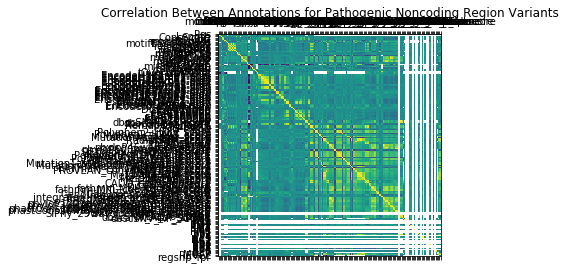

In [36]:
plt.matshow(pathogenic_noncoding_region_variants_with_nan.corr(method = 'pearson'))
annotations = ['Pos',
 'Length',
 'ConsScore',
 'GC',
 'CpG',
 'motifECount',
 'motifEHIPos',
 'motifEScoreChng',
 'cDNApos',
 'relcDNApos',
 'CDSpos',
 'relCDSpos',
 'protPos',
 'relProtPos',
 'Dst2Splice',
 'minDistTSS',
 'minDistTSE',
 'SIFTval',
 'mamPhCons',
 'verPhCons',
 'priPhyloP',
 'mamPhyloP',
 'verPhyloP',
 'bStatistic',
 'targetScan',
 'mirSVR-Score',
 'mirSVR-E',
 'mirSVR-Aln',
 'GerpRS',
 'GerpRSpval',
 'tOverlapMotifs',
 'motifDist',
 'EncodeH3K4me1-sum',
 'EncodeH3K4me1-max',
 'EncodeH3K4me2-sum',
 'EncodeH3K4me2-max',
 'EncodeH3K4me3-sum',
 'EncodeH3K4me3-max',
 'EncodeH3K9ac-sum',
 'EncodeH3K9ac-max',
 'EncodeH3K9me3-sum',
 'EncodeH3K9me3-max',
 'EncodeH3K27ac-sum',
 'EncodeH3K27ac-max',
 'EncodeH3K27me3-sum',
 'EncodeH3K27me3-max',
 'EncodeH3K36me3-sum',
 'EncodeH3K36me3-max',
 'EncodeH3K79me2-sum',
 'EncodeH3K79me2-max',
 'EncodeH4K20me1-sum',
 'EncodeH4K20me1-max',
 'EncodeH2AFZ-sum',
 'EncodeH2AFZ-max',
 'EncodeDNase-sum',
 'EncodeDNase-max',
 'EncodetotalRNA-sum',
 'EncodetotalRNA-max',
 'Grantham',
 'Dist2Mutation',
 'Freq100bp',
 'Rare100bp',
 'Sngl100bp',
 'Freq1000bp',
 'Rare1000bp',
 'Sngl1000bp',
 'Freq10000bp',
 'Rare10000bp',
 'Sngl10000bp',
 'dbscSNV-ada_score',
 'dbscSNV-rf_score',
 'RemapOverlapTF',
 'RemapOverlapCL',
 'RawScore',
 'PHRED',
 'End',
 'SIFT_score',
 'Polyphen2_HDIV_score',
 'Polyphen2_HVAR_score',
 'LRT_score',
 'MutationTaster_score',
 'MutationAssessor_score',
 'FATHMM_score',
 'RadialSVM_score',
 'LR_score',
 'VEST3_score',
 'CADD_raw',
 'CADD_phred',
 'GERP++_RS',
 'phyloP46way_placental',
 'phyloP100way_vertebrate',
 'SiPhy_29way_logOdds',
 'SIFT_score.1',
 'SIFT_converted_rankscore',
 'Polyphen2_HDIV_score.1',
 'Polyphen2_HDIV_rankscore',
 'Polyphen2_HVAR_score.1',
 'Polyphen2_HVAR_rankscore',
 'LRT_score.1',
 'LRT_converted_rankscore',
 'MutationTaster_score.1',
 'MutationTaster_converted_rankscore',
 'MutationAssessor_score.1',
 'MutationAssessor_score_rankscore',
 'FATHMM_score.1',
 'FATHMM_converted_rankscore',
 'PROVEAN_score',
 'PROVEAN_converted_rankscore',
 'VEST3_score.1',
 'VEST3_rankscore',
 'MetaSVM_score',
 'MetaSVM_rankscore',
 'MetaLR_score',
 'MetaLR_rankscore',
 'M-CAP_score',
 'M-CAP_rankscore',
 'CADD_raw.1',
 'CADD_raw_rankscore',
 'CADD_phred.1',
 'DANN_score',
 'DANN_rankscore',
 'fathmm-MKL_coding_score',
 'fathmm-MKL_coding_rankscore',
 'Eigen-raw',
 'Eigen-PC-raw',
 'GenoCanyon_score',
 'GenoCanyon_score_rankscore',
 'integrated_fitCons_score',
 'integrated_fitCons_score_rankscore',
 'integrated_confidence_value',
 'GERP++_RS.1',
 'GERP++_RS_rankscore',
 'phyloP100way_vertebrate.1',
 'phyloP100way_vertebrate_rankscore',
 'phyloP20way_mammalian',
 'phyloP20way_mammalian_rankscore',
 'phastCons100way_vertebrate',
 'phastCons100way_vertebrate_rankscore',
 'phastCons20way_mammalian',
 'phastCons20way_mammalian_rankscore',
 'SiPhy_29way_logOdds.1',
 'SiPhy_29way_logOdds_rankscore',
 'GTEx_V6_gene',
 'GTEx_V6_tissue',
 'dbscSNV_ADA_SCORE',
 'dbscSNV_RF_SCORE',
 'PVS1',
 'PS1',
 'PS2',
 'PS3',
 'PS4',
 'PM1',
 'PM2',
 'PM3',
 'PM4',
 'PM5',
 'PM6',
 'PP1',
 'PP2',
 'PP3',
 'PP4',
 'PP5',
 'BA1',
 'BS1',
 'BS2',
 'BS3',
 'BS4',
 'BP1',
 'BP2',
 'BP3',
 'BP4',
 'BP5',
 'BP6',
 'BP7',
 'MCAP',
 'REVEL',
 'regsnp_fpr']
x_pos = np.arange(len(annotations))
plt.xticks(x_pos, annotations)
y_pos = np.arange(len(annotations))
plt.yticks(y_pos, annotations)
plt.title('Correlation Between Annotations for Pathogenic Noncoding Region Variants')
plt.show()

We see that this graph is very similar to the others.

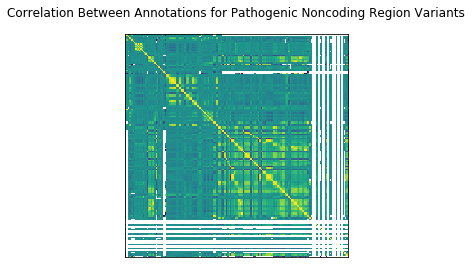

<Figure size 432x288 with 0 Axes>

In [44]:
plt.matshow(pathogenic_coding_region_variants_with_nan.corr(method = 'pearson'))
plt.title('Correlation Between Annotations for Pathogenic Noncoding Region Variants')
plt.xticks([])
plt.yticks([])
plt.show()

Below is the dataframe for the benign noncoding region:

In [2]:
benign_noncoding_final_dataframe_with_nan_and_floats = dd.read_csv('benign_noncoding_final_dataframe_with_nan_and_floats.csv', dtype={'AAChange.ensGene': 'object',
       'AAChange.knownGene': 'object',
       'AAChange.refGene': 'object',
       'Domain': 'object',
       'Eigen_coding_or_noncoding': 'object',
       'Exon': 'object',
       'ExonicFunc.ensGene': 'object',
       'ExonicFunc.knownGene': 'object',
       'ExonicFunc.refGene': 'object',
       'FATHMM_pred': 'object',
       'FATHMM_pred.1': 'object',
       'InterVar_automated': 'object',
       'Interpro_domain': 'object',
       'Interpro_domain.1': 'object',
       'LRT_pred': 'object',
       'LRT_pred.1': 'object',
       'LR_pred': 'object',
       'M-CAP_pred': 'object',
       'MetaLR_pred': 'object',
       'MetaSVM_pred': 'object',
       'MutationAssessor_pred': 'object',
       'MutationAssessor_pred.1': 'object',
       'MutationTaster_pred': 'object',
       'MutationTaster_pred.1': 'object',
       'PROVEAN_pred': 'object',
       'PolyPhenCat': 'object',
       'Polyphen2_HDIV_pred': 'object',
       'Polyphen2_HDIV_pred.1': 'object',
       'Polyphen2_HVAR_pred': 'object',
       'Polyphen2_HVAR_pred.1': 'object',
       'RadialSVM_pred': 'object',
       'SIFT_pred': 'object',
       'SIFT_pred.1': 'object',
       'SIFTcat': 'object',
       'cosmic70': 'object',
       'fathmm-MKL_coding_pred': 'object',
       'nAA': 'object',
       'oAA': 'object', 
        'GTEx_V6_gene': 'object',
       'GTEx_V6_tissue': 'object', '#Chrom': 'object'}).compute()

/opt/miniconda3/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (93) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/opt/miniconda3/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/opt/miniconda3/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (93,94,95,217,233,235) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/opt/miniconda3/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (93,94,233,235) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/opt/miniconda3/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (35,93,94,95,217,233,235

Again we cut out the columns not helpful to our model:

In [3]:
benign_noncoding_final_dataframe_with_nan_and_floats = benign_noncoding_final_dataframe_with_nan_and_floats.drop(['#Chrom', 'Pos', 'Length', 'End', 'Type', 'AnnoType'], axis = 1)

We set a new column so that we can distinguish this data from the other regions:

In [4]:
benign_noncoding_final_dataframe_with_nan_and_floats['category'] = 'benign_noncoding'

Below we keep only the columns which have numerical values:

In [5]:
benign_noncoding_region_for_pca = benign_noncoding_final_dataframe_with_nan_and_floats[['ConsScore', 'GC', 'CpG', 'motifECount', 'motifEHIPos', 'motifEScoreChng', 'cDNApos', 'relcDNApos', 'CDSpos', 'relCDSpos', 'protPos', 'relProtPos', 'Dst2Splice', 'minDistTSS', 'minDistTSE', 'SIFTval', 'mamPhCons', 'verPhCons', 'priPhyloP', 'mamPhyloP', 'verPhyloP', 'bStatistic', 'targetScan', 'mirSVR-Score', 'mirSVR-E', 'mirSVR-Aln', 'GerpRS', 'GerpRSpval', 'tOverlapMotifs', 'motifDist', 'EncodeH3K4me1-sum', 'EncodeH3K4me1-max', 'EncodeH3K4me2-sum', 'EncodeH3K4me2-max', 'EncodeH3K4me3-sum', 'EncodeH3K4me3-max', 'EncodeH3K9ac-sum', 'EncodeH3K9ac-max', 'EncodeH3K9me3-sum', 'EncodeH3K9me3-max', 'EncodeH3K27ac-sum', 'EncodeH3K27ac-max', 'EncodeH3K27me3-sum', 'EncodeH3K27me3-max', 'EncodeH3K36me3-sum', 'EncodeH3K36me3-max', 'EncodeH3K79me2-sum', 'EncodeH3K79me2-max', 'EncodeH4K20me1-sum', 'EncodeH4K20me1-max', 'EncodeH2AFZ-sum', 'EncodeH2AFZ-max', 'EncodeDNase-sum', 'EncodeDNase-max', 'EncodetotalRNA-sum', 'EncodetotalRNA-max', 'Grantham', 'Dist2Mutation', 'Freq100bp', 'Rare100bp', 'Sngl100bp', 'Freq1000bp', 'Rare1000bp', 'Sngl1000bp', 'Freq10000bp', 'Rare10000bp', 'Sngl10000bp', 'dbscSNV-ada_score', 'dbscSNV-rf_score', 'RemapOverlapTF', 'RemapOverlapCL', 'RawScore', 'PHRED', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score', 'LRT_score', 'MutationTaster_score', 'MutationAssessor_score', 'FATHMM_score', 'RadialSVM_score', 'LR_score', 'VEST3_score', 'CADD_raw', 'CADD_phred', 'GERP++_RS', 'phyloP46way_placental', 'phyloP100way_vertebrate', 'SiPhy_29way_logOdds', 'SIFT_score.1', 'SIFT_converted_rankscore', 'Polyphen2_HDIV_score.1', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score.1', 'Polyphen2_HVAR_rankscore', 'LRT_score.1', 'LRT_converted_rankscore', 'MutationTaster_score.1', 'MutationTaster_converted_rankscore', 'MutationAssessor_score.1', 'MutationAssessor_score_rankscore', 'FATHMM_score.1', 'FATHMM_converted_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST3_score.1', 'VEST3_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'CADD_raw.1', 'CADD_raw_rankscore', 'CADD_phred.1', 'DANN_score', 'DANN_rankscore', 'fathmm-MKL_coding_score', 'fathmm-MKL_coding_rankscore', 'Eigen-raw', 'Eigen-PC-raw', 'GenoCanyon_score', 'GenoCanyon_score_rankscore', 'integrated_fitCons_score', 'integrated_fitCons_score_rankscore', 'integrated_confidence_value', 'GERP++_RS.1', 'GERP++_RS_rankscore', 'phyloP100way_vertebrate.1', 'phyloP100way_vertebrate_rankscore', 'phyloP20way_mammalian', 'phyloP20way_mammalian_rankscore', 'phastCons100way_vertebrate', 'phastCons100way_vertebrate_rankscore', 'phastCons20way_mammalian', 'phastCons20way_mammalian_rankscore', 'SiPhy_29way_logOdds.1', 'SiPhy_29way_logOdds_rankscore', 'dbscSNV_ADA_SCORE', 'dbscSNV_RF_SCORE', 'PVS1', 'PS1', 'PS2', 'PS3', 'PS4', 'PM1', 'PM2', 'PM3', 'PM4', 'PM5', 'PM6', 'PP1', 'PP2', 'PP3', 'PP4', 'PP5', 'BA1', 'BS1', 'BS2', 'BS3', 'BS4', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'MCAP', 'REVEL', 'regsnp_fpr', 'category']]

Now we change the NaN values with 0 so that we can run PCA:

In [6]:
benign_noncoding_region_for_pca_without_categorical_columns_no_nan = benign_noncoding_region_for_pca.fillna(0)

Again we save the above dataframe for future use. However, this is in the form of a Dask Dataframe so I will need to be careful with using it in the future:

In [4]:
benign_noncoding_region_for_pca_without_categorical_columns_no_nan.to_csv('benign_noncoding_region_for_pca.csv')

NameError: name 'benign_noncoding_region_for_pca_without_categorical_columns_no_nan' is not defined

Below I have run the Pearson Correlation Test on the annotations for the benign noncoding region and created a graph that plots the correlation between the annotations:

In [6]:
correlation_for_benign_noncoding_region = pd.read_csv('benign_noncoding_final_dataframe_with_nan_and_floats.csv').drop(columns = ['Unnamed: 0', 'Unnamed: 0.1']).corr(method = 'pearson')
correlation_for_benign_noncoding_region

/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3,4,5,34,35,39,68,69,70,71,73,74,88,89,93,94,95,103,104,105,108,109,112,115,119,122,125,126,131,132,148,155,156,157,161,162,168,178,179,182,196,201,217,219,220,233,235) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,BA1,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BS1,BS2,...,priPhyloP,protPos,regsnp_fpr,relCDSpos,relProtPos,relcDNApos,tOverlapMotifs,targetScan,verPhCons,verPhyloP
BA1,1.000000,0.117589,NaN,NaN,-0.017008,NaN,0.497263,-0.013199,0.515783,NaN,...,-0.002712,-0.039042,NaN,0.000023,-0.000333,0.012265,NaN,NaN,0.021290,0.035332
BP1,0.117589,1.000000,NaN,NaN,-0.297567,NaN,0.290898,-0.304796,0.250455,NaN,...,0.109261,0.353429,NaN,0.018606,0.017619,0.082295,NaN,NaN,0.146008,0.252374
BP2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BP3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BP4,-0.017008,-0.297567,NaN,NaN,1.000000,NaN,-0.035350,0.597956,-0.028018,NaN,...,-0.241991,-0.073230,-0.263576,0.053966,0.053488,0.070623,0.062500,NaN,-0.234180,-0.438491
BP5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BP6,0.497263,0.290898,NaN,NaN,-0.035350,NaN,1.000000,0.016637,0.696879,NaN,...,0.071030,0.236390,NaN,0.015226,0.014211,0.082467,NaN,NaN,0.177764,0.163293
BP7,-0.013199,-0.304796,NaN,NaN,0.597956,NaN,0.016637,1.000000,-0.035663,NaN,...,-0.124951,0.050311,-0.263576,0.109390,0.107957,0.108398,0.338502,NaN,-0.023182,-0.334065
BS1,0.515783,0.250455,NaN,NaN,-0.028018,NaN,0.696879,-0.035663,1.000000,NaN,...,0.083429,0.068043,NaN,0.043559,0.042936,0.064654,NaN,NaN,0.110680,0.083213
BS2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below shows the list of annotations in the Pearson Correlation test:

In [7]:
list(correlation_for_benign_noncoding_region)

['BA1',
 'BP1',
 'BP2',
 'BP3',
 'BP4',
 'BP5',
 'BP6',
 'BP7',
 'BS1',
 'BS2',
 'BS3',
 'BS4',
 'CADD_phred',
 'CADD_phred.1',
 'CADD_raw',
 'CADD_raw.1',
 'CADD_raw_rankscore',
 'CDSpos',
 'ConsScore',
 'CpG',
 'DANN_rankscore',
 'DANN_score',
 'Dist2Mutation',
 'Dst2Splice',
 'Eigen-PC-raw',
 'Eigen-raw',
 'EncodeDNase-max',
 'EncodeDNase-sum',
 'EncodeH2AFZ-max',
 'EncodeH2AFZ-sum',
 'EncodeH3K27ac-max',
 'EncodeH3K27ac-sum',
 'EncodeH3K27me3-max',
 'EncodeH3K27me3-sum',
 'EncodeH3K36me3-max',
 'EncodeH3K36me3-sum',
 'EncodeH3K4me1-max',
 'EncodeH3K4me1-sum',
 'EncodeH3K4me2-max',
 'EncodeH3K4me2-sum',
 'EncodeH3K4me3-max',
 'EncodeH3K4me3-sum',
 'EncodeH3K79me2-max',
 'EncodeH3K79me2-sum',
 'EncodeH3K9ac-max',
 'EncodeH3K9ac-sum',
 'EncodeH3K9me3-max',
 'EncodeH3K9me3-sum',
 'EncodeH4K20me1-max',
 'EncodeH4K20me1-sum',
 'EncodetotalRNA-max',
 'EncodetotalRNA-sum',
 'End',
 'FATHMM_converted_rankscore',
 'FATHMM_score',
 'FATHMM_score.1',
 'Freq10000bp',
 'Freq1000bp',
 'Freq100bp',
 'GC',
 'GERP++_RS',
 'GERP++_RS.1',
 'GERP++_RS_rankscore',
 'GenoCanyon_score',
 'GenoCanyon_score_rankscore',
 'GerpRS',
 'GerpRSpval',
 'Grantham',
 'LRT_converted_rankscore',
 'LRT_score',
 'LRT_score.1',
 'LR_score',
 'Length',
 'M-CAP_rankscore',
 'M-CAP_score',
 'MCAP',
 'MetaLR_rankscore',
 'MetaLR_score',
 'MetaSVM_rankscore',
 'MetaSVM_score',
 'MutationAssessor_score',
 'MutationAssessor_score.1',
 'MutationAssessor_score_rankscore',
 'MutationTaster_converted_rankscore',
 'MutationTaster_score',
 'MutationTaster_score.1',
 'PHRED',
 'PM1',
 'PM2',
 'PM3',
 'PM4',
 'PM5',
 'PM6',
 'PP1',
 'PP2',
 'PP3',
 'PP4',
 'PP5',
 'PROVEAN_converted_rankscore',
 'PROVEAN_score',
 'PS1',
 'PS2',
 'PS3',
 'PS4',
 'PVS1',
 'Polyphen2_HDIV_rankscore',
 'Polyphen2_HDIV_score',
 'Polyphen2_HDIV_score.1',
 'Polyphen2_HVAR_rankscore',
 'Polyphen2_HVAR_score',
 'Polyphen2_HVAR_score.1',
 'Pos',
 'REVEL',
 'RadialSVM_score',
 'Rare10000bp',
 'Rare1000bp',
 'Rare100bp',
 'RawScore',
 'RemapOverlapCL',
 'RemapOverlapTF',
 'SIFT_converted_rankscore',
 'SIFT_score',
 'SIFT_score.1',
 'SIFTval',
 'SiPhy_29way_logOdds',
 'SiPhy_29way_logOdds.1',
 'SiPhy_29way_logOdds_rankscore',
 'Sngl10000bp',
 'Sngl1000bp',
 'Sngl100bp',
 'VEST3_rankscore',
 'VEST3_score',
 'VEST3_score.1',
 'bStatistic',
 'cDNApos',
 'dbscSNV-ada_score',
 'dbscSNV-rf_score',
 'dbscSNV_ADA_SCORE',
 'dbscSNV_RF_SCORE',
 'fathmm-MKL_coding_rankscore',
 'fathmm-MKL_coding_score',
 'integrated_confidence_value',
 'integrated_fitCons_score',
 'integrated_fitCons_score_rankscore',
 'mamPhCons',
 'mamPhyloP',
 'minDistTSE',
 'minDistTSS',
 'mirSVR-Aln',
 'mirSVR-E',
 'mirSVR-Score',
 'motifDist',
 'motifECount',
 'motifEHIPos',
 'motifEScoreChng',
 'phastCons100way_vertebrate',
 'phastCons100way_vertebrate_rankscore',
 'phastCons20way_mammalian',
 'phastCons20way_mammalian_rankscore',
 'phyloP100way_vertebrate',
 'phyloP100way_vertebrate.1',
 'phyloP100way_vertebrate_rankscore',
 'phyloP20way_mammalian',
 'phyloP20way_mammalian_rankscore',
 'phyloP46way_placental',
 'priPhyloP',
 'protPos',
 'regsnp_fpr',
 'relCDSpos',
 'relProtPos',
 'relcDNApos',
 'tOverlapMotifs',
 'targetScan',
 'verPhCons',
 'verPhyloP']

Below is the plot for the Pearson Correlation test for Benign noncoding region variants:

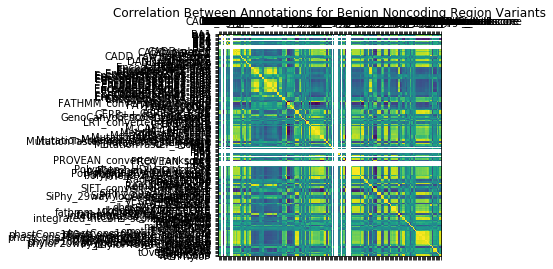

In [9]:
plt.matshow(correlation_for_benign_noncoding_region.corr(method = 'pearson'))
annotations = ['BA1', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'BS1', 'BS2', 'BS3', 'BS4', 'CADD_phred', 'CADD_phred.1', 'CADD_raw', 'CADD_raw.1', 'CADD_raw_rankscore', 'CDSpos', 'ConsScore', 'CpG', 'DANN_rankscore', 'DANN_score', 'Dist2Mutation', 'Dst2Splice', 'Eigen-PC-raw', 'Eigen-raw', 'EncodeDNase-max', 'EncodeDNase-sum', 'EncodeH2AFZ-max', 'EncodeH2AFZ-sum', 'EncodeH3K27ac-max', 'EncodeH3K27ac-sum', 'EncodeH3K27me3-max', 'EncodeH3K27me3-sum', 'EncodeH3K36me3-max', 'EncodeH3K36me3-sum', 'EncodeH3K4me1-max', 'EncodeH3K4me1-sum', 'EncodeH3K4me2-max', 'EncodeH3K4me2-sum', 'EncodeH3K4me3-max', 'EncodeH3K4me3-sum', 'EncodeH3K79me2-max', 'EncodeH3K79me2-sum', 'EncodeH3K9ac-max', 'EncodeH3K9ac-sum', 'EncodeH3K9me3-max', 'EncodeH3K9me3-sum', 'EncodeH4K20me1-max', 'EncodeH4K20me1-sum', 'EncodetotalRNA-max', 'EncodetotalRNA-sum', 'End', 'FATHMM_converted_rankscore', 'FATHMM_score', 'FATHMM_score.1', 'Freq10000bp', 'Freq1000bp', 'Freq100bp', 'GC', 'GERP++_RS', 'GERP++_RS.1', 'GERP++_RS_rankscore', 'GenoCanyon_score', 'GenoCanyon_score_rankscore', 'GerpRS', 'GerpRSpval', 'Grantham', 'LRT_converted_rankscore', 'LRT_score', 'LRT_score.1', 'LR_score', 'Length', 'M-CAP_rankscore', 'M-CAP_score', 'MCAP', 'MetaLR_rankscore', 'MetaLR_score', 'MetaSVM_rankscore', 'MetaSVM_score', 'MutationAssessor_score', 'MutationAssessor_score.1', 'MutationAssessor_score_rankscore', 'MutationTaster_converted_rankscore', 'MutationTaster_score', 'MutationTaster_score.1', 'PHRED', 'PM1', 'PM2', 'PM3', 'PM4', 'PM5', 'PM6', 'PP1', 'PP2', 'PP3', 'PP4', 'PP5', 'PROVEAN_converted_rankscore', 'PROVEAN_score', 'PS1', 'PS2', 'PS3', 'PS4', 'PVS1', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HDIV_score', 'Polyphen2_HDIV_score.1', 'Polyphen2_HVAR_rankscore', 'Polyphen2_HVAR_score', 'Polyphen2_HVAR_score.1', 'Pos', 'REVEL', 'RadialSVM_score', 'Rare10000bp', 'Rare1000bp', 'Rare100bp', 'RawScore', 'RemapOverlapCL', 'RemapOverlapTF', 'SIFT_converted_rankscore', 'SIFT_score', 'SIFT_score.1', 'SIFTval', 'SiPhy_29way_logOdds', 'SiPhy_29way_logOdds.1', 'SiPhy_29way_logOdds_rankscore', 'Sngl10000bp', 'Sngl1000bp', 'Sngl100bp', 'VEST3_rankscore', 'VEST3_score', 'VEST3_score.1', 'bStatistic', 'cDNApos', 'dbscSNV-ada_score', 'dbscSNV-rf_score', 'dbscSNV_ADA_SCORE', 'dbscSNV_RF_SCORE', 'fathmm-MKL_coding_rankscore', 'fathmm-MKL_coding_score', 'integrated_confidence_value', 'integrated_fitCons_score', 'integrated_fitCons_score_rankscore', 'mamPhCons', 'mamPhyloP', 'minDistTSE', 'minDistTSS', 'mirSVR-Aln', 'mirSVR-E', 'mirSVR-Score', 'motifDist', 'motifECount', 'motifEHIPos', 'motifEScoreChng', 'phastCons100way_vertebrate', 'phastCons100way_vertebrate_rankscore', 'phastCons20way_mammalian', 'phastCons20way_mammalian_rankscore', 'phyloP100way_vertebrate', 'phyloP100way_vertebrate.1', 'phyloP100way_vertebrate_rankscore', 'phyloP20way_mammalian', 'phyloP20way_mammalian_rankscore', 'phyloP46way_placental', 'priPhyloP', 'protPos', 'regsnp_fpr', 'relCDSpos', 'relProtPos', 'relcDNApos', 'tOverlapMotifs', 'targetScan', 'verPhCons', 'verPhyloP']
x_pos = np.arange(len(annotations))
plt.xticks(x_pos, annotations)
y_pos = np.arange(len(annotations))
plt.yticks(y_pos, annotations)
plt.title('Correlation Between Annotations for Benign Noncoding Region Variants')
plt.show()

These graphs show a bit more yellow and green than blue, which means the scores seem to be more correlated with each other than in the previous files:

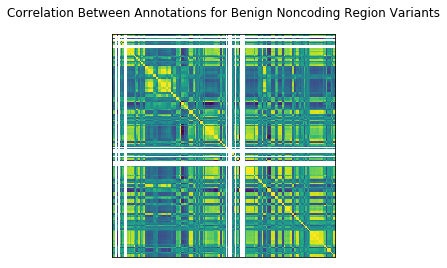

In [10]:
plt.matshow(correlation_for_benign_noncoding_region.corr(method = 'pearson'))
plt.title('Correlation Between Annotations for Benign Noncoding Region Variants')
plt.xticks([])
plt.yticks([])
plt.show()

Creating a plot for all variants in one file, we see the following:

In [3]:
all_variants_for_pca = pd.read_csv('all_variants_for_pca.csv')

Below is the Pearson Correlation Table:

In [25]:
correlation_for_variants = all_variants_for_pca.corr(method = 'pearson')
correlation_for_variants

,Unnamed: 0,Unnamed: 0.1,ConsScore,GC,CpG,motifECount,motifEHIPos,motifEScoreChng,cDNApos,relcDNApos,...,BP1,BP2,BP3,BP4,BP5,BP6,BP7,MCAP,REVEL,regsnp_fpr
Unnamed: 0,1.000000,0.348137,0.280476,0.163434,0.216597,0.059497,0.037869,-0.030480,0.092302,0.277239,...,0.029780,NaN,NaN,0.037003,NaN,0.031309,0.032723,0.101822,0.115173,-0.068933
Unnamed: 0.1,0.348137,1.000000,0.232439,0.168147,0.204241,0.061778,0.039356,-0.032827,0.049417,0.235968,...,0.017020,NaN,NaN,0.061570,NaN,-0.019802,0.054250,0.152443,0.157872,-0.040615
ConsScore,0.280476,0.232439,1.000000,0.153203,0.155079,0.043920,0.032461,-0.024959,0.208713,0.547290,...,0.040561,NaN,NaN,0.049099,NaN,0.026124,0.032054,0.114475,0.131493,-0.051631
GC,0.163434,0.168147,0.153203,1.000000,0.698715,0.099523,0.085095,-0.072274,0.019393,0.110798,...,0.015602,NaN,NaN,0.054014,NaN,0.016312,0.043397,0.047086,0.048510,0.035332
CpG,0.216597,0.204241,0.155079,0.698715,1.000000,0.151489,0.122234,-0.104048,0.015608,0.090107,...,0.016474,NaN,NaN,0.060745,NaN,0.017049,0.047406,0.042705,0.037674,0.004034
motifECount,0.059497,0.061778,0.043920,0.099523,0.151489,1.000000,0.316011,-0.188169,-0.004937,-0.005820,...,-0.000506,NaN,NaN,0.001387,NaN,0.001212,-0.000536,0.011694,0.008155,-0.004823
motifEHIPos,0.037869,0.039356,0.032461,0.085095,0.122234,0.316011,1.000000,-0.569588,-0.004380,-0.006849,...,0.000437,NaN,NaN,0.003523,NaN,-0.000856,0.000881,0.004986,0.002162,-0.000306
motifEScoreChng,-0.030480,-0.032827,-0.024959,-0.072274,-0.104048,-0.188169,-0.569588,1.000000,0.004075,0.005211,...,0.001152,NaN,NaN,-0.003759,NaN,0.001377,-0.001842,-0.002593,-0.000838,0.001562
cDNApos,0.092302,0.049417,0.208713,0.019393,0.015608,-0.004937,-0.004380,0.004075,1.000000,0.376206,...,0.114066,NaN,NaN,0.056457,NaN,0.067675,0.055469,0.031465,0.045272,-0.017690
relcDNApos,0.277239,0.235968,0.547290,0.110798,0.090107,-0.005820,-0.006849,0.005211,0.376206,1.000000,...,0.042209,NaN,NaN,0.069345,NaN,0.035654,0.058419,0.097079,0.113783,-0.049863


Below is a graph to show the correlations between the chart above, just as we had done before:

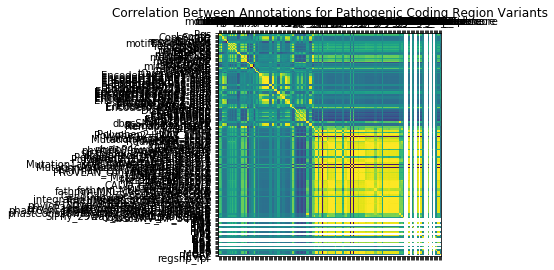

In [26]:
plt.matshow(correlation_for_variants.corr(method = 'pearson'))
annotations = ['Pos',
 'Length',
 'ConsScore',
 'GC',
 'CpG',
 'motifECount',
 'motifEHIPos',
 'motifEScoreChng',
 'cDNApos',
 'relcDNApos',
 'CDSpos',
 'relCDSpos',
 'protPos',
 'relProtPos',
 'Dst2Splice',
 'minDistTSS',
 'minDistTSE',
 'SIFTval',
 'mamPhCons',
 'verPhCons',
 'priPhyloP',
 'mamPhyloP',
 'verPhyloP',
 'bStatistic',
 'targetScan',
 'mirSVR-Score',
 'mirSVR-E',
 'mirSVR-Aln',
 'GerpRS',
 'GerpRSpval',
 'tOverlapMotifs',
 'motifDist',
 'EncodeH3K4me1-sum',
 'EncodeH3K4me1-max',
 'EncodeH3K4me2-sum',
 'EncodeH3K4me2-max',
 'EncodeH3K4me3-sum',
 'EncodeH3K4me3-max',
 'EncodeH3K9ac-sum',
 'EncodeH3K9ac-max',
 'EncodeH3K9me3-sum',
 'EncodeH3K9me3-max',
 'EncodeH3K27ac-sum',
 'EncodeH3K27ac-max',
 'EncodeH3K27me3-sum',
 'EncodeH3K27me3-max',
 'EncodeH3K36me3-sum',
 'EncodeH3K36me3-max',
 'EncodeH3K79me2-sum',
 'EncodeH3K79me2-max',
 'EncodeH4K20me1-sum',
 'EncodeH4K20me1-max',
 'EncodeH2AFZ-sum',
 'EncodeH2AFZ-max',
 'EncodeDNase-sum',
 'EncodeDNase-max',
 'EncodetotalRNA-sum',
 'EncodetotalRNA-max',
 'Grantham',
 'Dist2Mutation',
 'Freq100bp',
 'Rare100bp',
 'Sngl100bp',
 'Freq1000bp',
 'Rare1000bp',
 'Sngl1000bp',
 'Freq10000bp',
 'Rare10000bp',
 'Sngl10000bp',
 'dbscSNV-ada_score',
 'dbscSNV-rf_score',
 'RemapOverlapTF',
 'RemapOverlapCL',
 'RawScore',
 'PHRED',
 'End',
 'SIFT_score',
 'Polyphen2_HDIV_score',
 'Polyphen2_HVAR_score',
 'LRT_score',
 'MutationTaster_score',
 'MutationAssessor_score',
 'FATHMM_score',
 'RadialSVM_score',
 'LR_score',
 'VEST3_score',
 'CADD_raw',
 'CADD_phred',
 'GERP++_RS',
 'phyloP46way_placental',
 'phyloP100way_vertebrate',
 'SiPhy_29way_logOdds',
 'SIFT_score.1',
 'SIFT_converted_rankscore',
 'Polyphen2_HDIV_score.1',
 'Polyphen2_HDIV_rankscore',
 'Polyphen2_HVAR_score.1',
 'Polyphen2_HVAR_rankscore',
 'LRT_score.1',
 'LRT_converted_rankscore',
 'MutationTaster_score.1',
 'MutationTaster_converted_rankscore',
 'MutationAssessor_score.1',
 'MutationAssessor_score_rankscore',
 'FATHMM_score.1',
 'FATHMM_converted_rankscore',
 'PROVEAN_score',
 'PROVEAN_converted_rankscore',
 'VEST3_score.1',
 'VEST3_rankscore',
 'MetaSVM_score',
 'MetaSVM_rankscore',
 'MetaLR_score',
 'MetaLR_rankscore',
 'M-CAP_score',
 'M-CAP_rankscore',
 'CADD_raw.1',
 'CADD_raw_rankscore',
 'CADD_phred.1',
 'DANN_score',
 'DANN_rankscore',
 'fathmm-MKL_coding_score',
 'fathmm-MKL_coding_rankscore',
 'Eigen-raw',
 'Eigen-PC-raw',
 'GenoCanyon_score',
 'GenoCanyon_score_rankscore',
 'integrated_fitCons_score',
 'integrated_fitCons_score_rankscore',
 'integrated_confidence_value',
 'GERP++_RS.1',
 'GERP++_RS_rankscore',
 'phyloP100way_vertebrate.1',
 'phyloP100way_vertebrate_rankscore',
 'phyloP20way_mammalian',
 'phyloP20way_mammalian_rankscore',
 'phastCons100way_vertebrate',
 'phastCons100way_vertebrate_rankscore',
 'phastCons20way_mammalian',
 'phastCons20way_mammalian_rankscore',
 'SiPhy_29way_logOdds.1',
 'SiPhy_29way_logOdds_rankscore',
 'dbscSNV_ADA_SCORE',
 'dbscSNV_RF_SCORE',
 'PVS1',
 'PS1',
 'PS2',
 'PS3',
 'PS4',
 'PM1',
 'PM2',
 'PM3',
 'PM4',
 'PM5',
 'PM6',
 'PP1',
 'PP2',
 'PP3',
 'PP4',
 'PP5',
 'BA1',
 'BS1',
 'BS2',
 'BS3',
 'BS4',
 'BP1',
 'BP2',
 'BP3',
 'BP4',
 'BP5',
 'BP6',
 'BP7',
 'MCAP',
 'REVEL',
 'regsnp_fpr']
x_pos = np.arange(len(annotations))
plt.xticks(x_pos, annotations)
y_pos = np.arange(len(annotations))
plt.yticks(y_pos, annotations)
plt.title('Correlation Between Annotations for Pathogenic Coding Region Variants')
plt.show()

Below we do not call the PCA on the chart, but on the whole file itself:

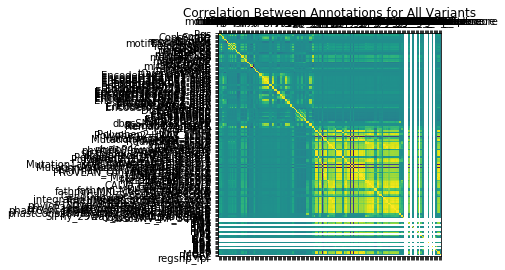

In [28]:
plt.matshow(correlation_for_variants)
annotations = ['Pos',
 'Length',
 'ConsScore',
 'GC',
 'CpG',
 'motifECount',
 'motifEHIPos',
 'motifEScoreChng',
 'cDNApos',
 'relcDNApos',
 'CDSpos',
 'relCDSpos',
 'protPos',
 'relProtPos',
 'Dst2Splice',
 'minDistTSS',
 'minDistTSE',
 'SIFTval',
 'mamPhCons',
 'verPhCons',
 'priPhyloP',
 'mamPhyloP',
 'verPhyloP',
 'bStatistic',
 'targetScan',
 'mirSVR-Score',
 'mirSVR-E',
 'mirSVR-Aln',
 'GerpRS',
 'GerpRSpval',
 'tOverlapMotifs',
 'motifDist',
 'EncodeH3K4me1-sum',
 'EncodeH3K4me1-max',
 'EncodeH3K4me2-sum',
 'EncodeH3K4me2-max',
 'EncodeH3K4me3-sum',
 'EncodeH3K4me3-max',
 'EncodeH3K9ac-sum',
 'EncodeH3K9ac-max',
 'EncodeH3K9me3-sum',
 'EncodeH3K9me3-max',
 'EncodeH3K27ac-sum',
 'EncodeH3K27ac-max',
 'EncodeH3K27me3-sum',
 'EncodeH3K27me3-max',
 'EncodeH3K36me3-sum',
 'EncodeH3K36me3-max',
 'EncodeH3K79me2-sum',
 'EncodeH3K79me2-max',
 'EncodeH4K20me1-sum',
 'EncodeH4K20me1-max',
 'EncodeH2AFZ-sum',
 'EncodeH2AFZ-max',
 'EncodeDNase-sum',
 'EncodeDNase-max',
 'EncodetotalRNA-sum',
 'EncodetotalRNA-max',
 'Grantham',
 'Dist2Mutation',
 'Freq100bp',
 'Rare100bp',
 'Sngl100bp',
 'Freq1000bp',
 'Rare1000bp',
 'Sngl1000bp',
 'Freq10000bp',
 'Rare10000bp',
 'Sngl10000bp',
 'dbscSNV-ada_score',
 'dbscSNV-rf_score',
 'RemapOverlapTF',
 'RemapOverlapCL',
 'RawScore',
 'PHRED',
 'End',
 'SIFT_score',
 'Polyphen2_HDIV_score',
 'Polyphen2_HVAR_score',
 'LRT_score',
 'MutationTaster_score',
 'MutationAssessor_score',
 'FATHMM_score',
 'RadialSVM_score',
 'LR_score',
 'VEST3_score',
 'CADD_raw',
 'CADD_phred',
 'GERP++_RS',
 'phyloP46way_placental',
 'phyloP100way_vertebrate',
 'SiPhy_29way_logOdds',
 'SIFT_score.1',
 'SIFT_converted_rankscore',
 'Polyphen2_HDIV_score.1',
 'Polyphen2_HDIV_rankscore',
 'Polyphen2_HVAR_score.1',
 'Polyphen2_HVAR_rankscore',
 'LRT_score.1',
 'LRT_converted_rankscore',
 'MutationTaster_score.1',
 'MutationTaster_converted_rankscore',
 'MutationAssessor_score.1',
 'MutationAssessor_score_rankscore',
 'FATHMM_score.1',
 'FATHMM_converted_rankscore',
 'PROVEAN_score',
 'PROVEAN_converted_rankscore',
 'VEST3_score.1',
 'VEST3_rankscore',
 'MetaSVM_score',
 'MetaSVM_rankscore',
 'MetaLR_score',
 'MetaLR_rankscore',
 'M-CAP_score',
 'M-CAP_rankscore',
 'CADD_raw.1',
 'CADD_raw_rankscore',
 'CADD_phred.1',
 'DANN_score',
 'DANN_rankscore',
 'fathmm-MKL_coding_score',
 'fathmm-MKL_coding_rankscore',
 'Eigen-raw',
 'Eigen-PC-raw',
 'GenoCanyon_score',
 'GenoCanyon_score_rankscore',
 'integrated_fitCons_score',
 'integrated_fitCons_score_rankscore',
 'integrated_confidence_value',
 'GERP++_RS.1',
 'GERP++_RS_rankscore',
 'phyloP100way_vertebrate.1',
 'phyloP100way_vertebrate_rankscore',
 'phyloP20way_mammalian',
 'phyloP20way_mammalian_rankscore',
 'phastCons100way_vertebrate',
 'phastCons100way_vertebrate_rankscore',
 'phastCons20way_mammalian',
 'phastCons20way_mammalian_rankscore',
 'SiPhy_29way_logOdds.1',
 'SiPhy_29way_logOdds_rankscore',
 'dbscSNV_ADA_SCORE',
 'dbscSNV_RF_SCORE',
 'PVS1',
 'PS1',
 'PS2',
 'PS3',
 'PS4',
 'PM1',
 'PM2',
 'PM3',
 'PM4',
 'PM5',
 'PM6',
 'PP1',
 'PP2',
 'PP3',
 'PP4',
 'PP5',
 'BA1',
 'BS1',
 'BS2',
 'BS3',
 'BS4',
 'BP1',
 'BP2',
 'BP3',
 'BP4',
 'BP5',
 'BP6',
 'BP7',
 'MCAP',
 'REVEL',
 'regsnp_fpr']
x_pos = np.arange(len(annotations))
plt.xticks(x_pos, annotations)
y_pos = np.arange(len(annotations))
plt.yticks(y_pos, annotations)
plt.title('Correlation Between Annotations for All Variants')
plt.show()

# PCA:

Below we combine all the dataframes into one. This will allow us to see the differences between the annotation scores of the separate regions, if there are any. We have to append the dataframes one by one using 32 GB of RAM since the files are so large. Also, we keep only the columns that have numerical values in them:

In [12]:
df_for_pca_1 = dd.read_csv('benign_noncoding_region_for_pca.csv', dtype={'AAChange.ensGene': 'object',
       'AAChange.knownGene': 'object',
       'AAChange.refGene': 'object',
       'Domain': 'object',
       'Eigen_coding_or_noncoding': 'object',
       'Exon': 'object',
       'ExonicFunc.ensGene': 'object',
       'ExonicFunc.knownGene': 'object',
       'ExonicFunc.refGene': 'object',
       'FATHMM_pred': 'object',
       'FATHMM_pred.1': 'object',
       'InterVar_automated': 'object',
       'Interpro_domain': 'object',
       'Interpro_domain.1': 'object',
       'LRT_pred': 'object',
       'LRT_pred.1': 'object',
       'LR_pred': 'object',
       'M-CAP_pred': 'object',
       'MetaLR_pred': 'object',
       'MetaSVM_pred': 'object',
       'MutationAssessor_pred': 'object',
       'MutationAssessor_pred.1': 'object',
       'MutationTaster_pred': 'object',
       'MutationTaster_pred.1': 'object',
       'PROVEAN_pred': 'object',
       'PolyPhenCat': 'object',
       'Polyphen2_HDIV_pred': 'object',
       'Polyphen2_HDIV_pred.1': 'object',
       'Polyphen2_HVAR_pred': 'object',
       'Polyphen2_HVAR_pred.1': 'object',
       'RadialSVM_pred': 'object',
       'SIFT_pred': 'object',
       'SIFT_pred.1': 'object',
       'SIFTcat': 'object',
       'cosmic70': 'object',
       'fathmm-MKL_coding_pred': 'object',
       'nAA': 'object',
       'oAA': 'object', 
        'GTEx_V6_gene': 'object',
       'GTEx_V6_tissue': 'object', '#Chrom': 'object'}).compute().append(pd.read_csv('pathogenic_noncoding_region_for_pca.csv'), ignore_index = True)
df_for_pca_1.drop(columns = ['Unnamed: 0'])

,ConsScore,GC,CpG,...,REVEL,regsnp_fpr,category
0,4,0.649,0.027,...,0.000,0.0,benign_noncoding
1,2,0.649,0.027,...,0.000,0.0,benign_noncoding
2,4,0.596,0.027,...,0.000,0.0,benign_noncoding
3,2,0.596,0.027,...,0.000,0.0,benign_noncoding
...,...,...,...,...,...,...,...
1550203,8,0.636,0.067,...,0.000,0.0,pathogenic_noncoding
1550204,1,0.636,0.067,...,0.000,0.0,pathogenic_noncoding
1550205,1,0.636,0.053,...,0.869,0.0,pathogenic_noncoding
1550206,6,0.636,0.053,...,0.869,0.0,pathogenic_noncoding


In [13]:
df_for_pca_2 = df_for_pca_1.append(pd.read_csv('pathogenic_coding_region_for_pca.csv'), ignore_index = True)
df_for_pca_2.drop(columns = ['Unnamed: 0'])

,ConsScore,GC,CpG,...,REVEL,regsnp_fpr,category
0,4.0,0.649,0.027,...,0.000,0.0,benign_noncoding
1,2.0,0.649,0.027,...,0.000,0.0,benign_noncoding
2,4.0,0.596,0.027,...,0.000,0.0,benign_noncoding
3,2.0,0.596,0.027,...,0.000,0.0,benign_noncoding
...,...,...,...,...,...,...,...
1670496,7.0,0.424,0.013,...,0.222,0.0,pathogenic_coding
1670497,4.0,0.424,0.013,...,0.222,0.0,pathogenic_coding
1670498,7.0,0.375,0.000,...,0.000,0.0,pathogenic_coding
1670499,2.0,0.375,0.000,...,0.000,0.0,pathogenic_coding


In [14]:
df_for_pca_final = df_for_pca_2.append(pd.read_csv('benign_coding_region_for_pca.csv'), ignore_index = True)
df_for_pca_final.drop(columns = ['Unnamed: 0'])

,ConsScore,GC,CpG,...,REVEL,regsnp_fpr,category
0,4.0,0.649,0.027,...,0.0,0.0,benign_noncoding
1,2.0,0.649,0.027,...,0.0,0.0,benign_noncoding
2,4.0,0.596,0.027,...,0.0,0.0,benign_noncoding
3,2.0,0.596,0.027,...,0.0,0.0,benign_noncoding
...,...,...,...,...,...,...,...
1801867,2.0,0.377,0.013,...,0.0,0.0,benign_coding
1801868,4.0,0.695,0.147,...,0.0,0.0,benign_coding
1801869,2.0,0.695,0.147,...,0.0,0.0,benign_coding
1801870,1.0,0.695,0.147,...,0.0,0.0,benign_coding


Below we have saved the resulting dataframe for use in PCA:

In [15]:
df_for_pca_final.to_csv('all_variants_for_pca.csv')

Below we have created a function that shows us the data using PCA in two dimensions in a grid plot. This method was found from https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

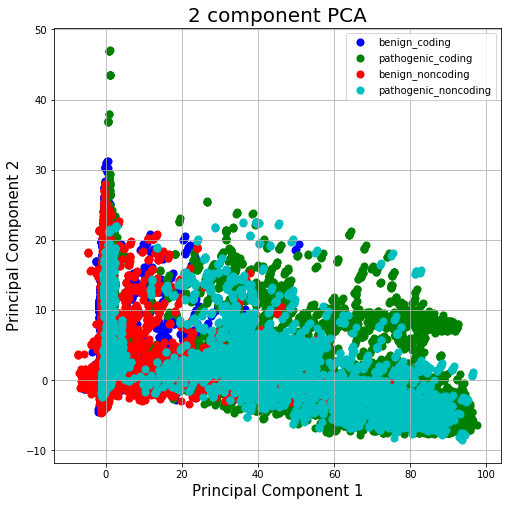

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
features = ['ConsScore', 'GC', 'CpG', 'motifECount', 'motifEHIPos', 'motifEScoreChng', 'cDNApos', 'relcDNApos', 'CDSpos', 'relCDSpos', 'protPos', 'relProtPos', 'Dst2Splice', 'minDistTSS', 'minDistTSE', 'SIFTval', 'mamPhCons', 'verPhCons', 'priPhyloP', 'mamPhyloP', 'verPhyloP', 'bStatistic', 'targetScan', 'mirSVR-Score', 'mirSVR-E', 'mirSVR-Aln', 'GerpRS', 'GerpRSpval', 'tOverlapMotifs', 'motifDist', 'EncodeH3K4me1-sum', 'EncodeH3K4me1-max', 'EncodeH3K4me2-sum', 'EncodeH3K4me2-max', 'EncodeH3K4me3-sum', 'EncodeH3K4me3-max', 'EncodeH3K9ac-sum', 'EncodeH3K9ac-max', 'EncodeH3K9me3-sum', 'EncodeH3K9me3-max', 'EncodeH3K27ac-sum', 'EncodeH3K27ac-max', 'EncodeH3K27me3-sum', 'EncodeH3K27me3-max', 'EncodeH3K36me3-sum', 'EncodeH3K36me3-max', 'EncodeH3K79me2-sum', 'EncodeH3K79me2-max', 'EncodeH4K20me1-sum', 'EncodeH4K20me1-max', 'EncodeH2AFZ-sum', 'EncodeH2AFZ-max', 'EncodeDNase-sum', 'EncodeDNase-max', 'EncodetotalRNA-sum', 'EncodetotalRNA-max', 'Grantham', 'Dist2Mutation', 'Freq100bp', 'Rare100bp', 'Sngl100bp', 'Freq1000bp', 'Rare1000bp', 'Sngl1000bp', 'Freq10000bp', 'Rare10000bp', 'Sngl10000bp', 'dbscSNV-ada_score', 'dbscSNV-rf_score', 'RemapOverlapTF', 'RemapOverlapCL', 'RawScore', 'PHRED', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score', 'LRT_score', 'MutationTaster_score', 'MutationAssessor_score', 'FATHMM_score', 'RadialSVM_score', 'LR_score', 'VEST3_score', 'CADD_raw', 'CADD_phred', 'GERP++_RS', 'phyloP46way_placental', 'phyloP100way_vertebrate', 'SiPhy_29way_logOdds', 'SIFT_score.1', 'SIFT_converted_rankscore', 'Polyphen2_HDIV_score.1', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score.1', 'Polyphen2_HVAR_rankscore', 'LRT_score.1', 'LRT_converted_rankscore', 'MutationTaster_score.1', 'MutationTaster_converted_rankscore', 'MutationAssessor_score.1', 'MutationAssessor_score_rankscore', 'FATHMM_score.1', 'FATHMM_converted_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST3_score.1', 'VEST3_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'CADD_raw.1', 'CADD_raw_rankscore', 'CADD_phred.1', 'DANN_score', 'DANN_rankscore', 'fathmm-MKL_coding_score', 'fathmm-MKL_coding_rankscore', 'Eigen-raw', 'Eigen-PC-raw', 'GenoCanyon_score', 'GenoCanyon_score_rankscore', 'integrated_fitCons_score', 'integrated_fitCons_score_rankscore', 'integrated_confidence_value', 'GERP++_RS.1', 'GERP++_RS_rankscore', 'phyloP100way_vertebrate.1', 'phyloP100way_vertebrate_rankscore', 'phyloP20way_mammalian', 'phyloP20way_mammalian_rankscore', 'phastCons100way_vertebrate', 'phastCons100way_vertebrate_rankscore', 'phastCons20way_mammalian', 'phastCons20way_mammalian_rankscore', 'SiPhy_29way_logOdds.1', 'SiPhy_29way_logOdds_rankscore', 'dbscSNV_ADA_SCORE', 'dbscSNV_RF_SCORE', 'PVS1', 'PS1', 'PS2', 'PS3', 'PS4', 'PM1', 'PM2', 'PM3', 'PM4', 'PM5', 'PM6', 'PP1', 'PP2', 'PP3', 'PP4', 'PP5', 'BA1', 'BS1', 'BS2', 'BS3', 'BS4', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'MCAP', 'REVEL', 'regsnp_fpr']
x = df_for_pca_final.loc[:, features].values
x = StandardScaler().fit_transform(x)
y = df_for_pca_final.loc[:,['category']].values
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']
finalDf = pd.concat([principalDf, df_for_pca_final[['category']]], axis = 1, ignore_index = False)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['benign_coding', 'pathogenic_coding', 'benign_noncoding', 'pathogenic_noncoding']
colors = ['b', 'g', 'r', 'c']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['category'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'], finalDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
ax.legend(targets)
ax.grid()